# Imports

In [877]:
import pandas as pd
from scipy import stats
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

import matplotlib
# just so saved plots aren't also shown
matplotlib.use('Agg')

import pymc3 as pm
import theano as T
import theano.tensor as tt
import arviz as az

from importlib import reload

import functions

In [880]:
# packages versions
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.2.3
numpy==1.20.3
pymc3==3.11.2
theano==1.1.2
arviz==0.11.4
matplotlib==3.2.2


# Look at raw data

In [7]:
raw_data, data, possible_observations, possible_utterances = functions.get_and_clean_data()

8  were excluded because incompletely recorded
88  were excluded because literally false


In [8]:
data.shape

(1104, 6)

In [9]:
raw_data.columns

Index(['submission_id', 'QUD', 'RT', 'age', 'choice_options_1',
       'choice_options_2', 'choice_options_3', 'column_number', 'comments',
       'condition', 'correct', 'education', 'endTime', 'expected',
       'experiment_id', 'gender', 'languages', 'prolific_id', 'question',
       'response', 'row_number', 'sentence_chunk_1', 'sentence_chunk_2',
       'sentence_chunk_3', 'sentence_chunk_4', 'sitation_number', 'situation',
       'startDate', 'startTime', 'stimulus', 'timeSpent', 'trial_name',
       'trial_number'],
      dtype='object')

In [10]:
raw_data.iloc[0]

submission_id                                                   11733
QUD                                                               NaN
RT                                                              35186
age                                                              24.0
choice_options_1                                   all|most|some|none
choice_options_2                                   all|most|some|none
choice_options_3                                          right|wrong
column_number                                                       5
comments                                                          NaN
condition                                                        high
correct                                                   placeholder
education                                           Graduated College
endTime                                                 1580416450279
expected                                                  placeholder
experiment_id       

In [11]:
raw_data['trial_name'].unique()

array(['training_trials', 'main_trials'], dtype=object)

In [12]:
# make sure that the row_number column doesn't contain NaNs or anything strange
raw_data.row_number.str.split('|', expand=True).stack().unique()

array(['9', '3', '12', '0'], dtype=object)

In [13]:
raw_data['row_number'].unique()

array(['9|9|3|3|3', '12|12|0|0|0', '12|12|12|12|12', '9|9|0|0|0',
       '12|12|9|0|0', '12|12|12|9|9', '12|12|12|0|0', '9|9|9|3|3',
       '9|9|9|9|9', '3|3|3|0|0', '12|12|3|0|0', '12|12|12|3|3',
       '12|12|3|3|3', '0|0|0|0|0', '3|3|3|3|3', '12|12|9|3|3',
       '12|12|9|9|9', '3|3|0|0|0', '9|9|9|0|0', '9|9|3|0|0'], dtype=object)

In [14]:
data['row_number'].iloc[0]

[12, 12, 12, 12, 12]

In [15]:
data

,condition,response,row_number,trial_name,index_observation,index_utterance
0,1,"[all, all, right]","[12, 12, 12, 12, 12]",main_trials,2,30
1,0,"[most, all, wrong]","[9, 9, 0, 0, 0]",main_trials,3,23
2,1,"[all, some, right]","[9, 9, 3, 3, 3]",main_trials,0,26
3,0,"[some, all, wrong]","[12, 12, 9, 0, 0]",main_trials,4,15
4,0,"[some, some, wrong]","[12, 12, 12, 9, 9]",main_trials,5,11
...,...,...,...,...,...,...
1195,1,"[some, all, right]","[12, 12, 0, 0, 0]",main_trials,1,14
1196,0,"[some, most, wrong]","[9, 9, 0, 0, 0]",main_trials,3,13
1197,1,"[some, some, right]","[3, 3, 3, 0, 0]",main_trials,9,10
1198,0,"[most, most, wrong]","[9, 9, 3, 3, 3]",main_trials,0,21


NOTE: some utterances were never produced in the experiment! Namely, the following ones:

In [670]:
us = ['|'.join(u) for u in data['response']]

possible_utterances[[
    u not in us
    for u 
    in ['|'.join(u) for u in possible_utterances]
]]

array([['none', 'some', 'right'],
       ['none', 'most', 'right'],
       ['none', 'most', 'wrong'],
       ['some', 'none', 'wrong'],
       ['most', 'none', 'wrong']], dtype='<U5')

Double check with example:

In [669]:
'none|some|right' in raw_data['response']

False

# Basic model in Numpy

Summary of the model:

- This is a production model, i.e. calculates the probability of each possible utterance given the parameters and observations
- In particular, there are 4 x 4 x 2 possible utterances
- Possible quantifiers: none, some, most, all
- There are 20 possible observations (can be seen with `raw_data['row_number'].unique()`)
    - Note that since the rows are always in decreasing order in the experiment, I don't need to worry about equivalent observations
- Need to calculate: 
    - p( utterance | gamma ): marginalized across possible observations
    - p( state | utterance )

In [16]:
reload(functions)

<module 'functions' from '/mnt/c/Users/faust/Dropbox/Tubingen/argumentative_language/functions.py'>

## Display loglikelihood of basic model

In [883]:
functions.calculate_logp_data(data, 1, 0.5, possible_observations, possible_utterances, True)

array([-9.49218059e-02, -4.85873522e-02, -1.98953602e+00, ...,
       -1.68279487e+00, -1.06357412e-02, -1.41322614e+01])

In [220]:
alphas, betas = np.mgrid[0.1:5:20j, 0.8:1:20j]

loglik_data = np.array([
    functions.calculate_logp_data(
        data, a, b, possible_observations, 
        possible_utterances, like_cogsci_paper=True
    ).sum()
    for a, b in zip(alphas.flatten(), betas.flatten())
]).reshape(*alphas.shape)

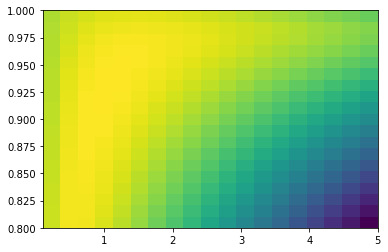

In [224]:
plt.pcolor(alphas, betas, loglik_data)

## Display argstrengths and S1 probs

In [884]:
xlabels = [','.join(a) for a in possible_utterances]

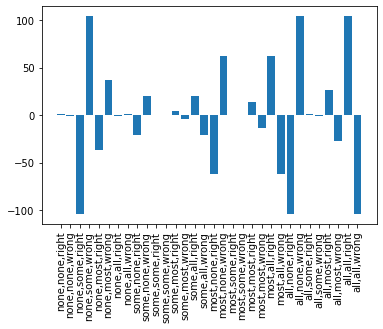

In [887]:
argumentative_strengths = functions.calculate_argumentative_strength(
    possible_utterances, possible_observations,
    0.85, 0.15
)

fig, ax = plt.subplots()
ax.bar(np.arange(len(argumentative_strengths)), argumentative_strengths)
ax.set_xticks(range(len(argumentative_strengths)))
ax.set_xticklabels(xlabels, rotation=90)
plt.show()

In [889]:
utterance_observation_compatibility = np.stack([
    functions.verify(*a, possible_observations)
    for a in possible_utterances
])

p_observation_given_utterance = (
    utterance_observation_compatibility / 
    utterance_observation_compatibility.sum(0, keepdims=True)
)

In [892]:
p_utterance_given_observation = functions.calculate_pragmatic_speaker(
    argumentative_strengths, 
    p_observation_given_utterance,
    costs=functions.get_costs(possible_utterances), 
    alpha=1.1, 
    beta=0.8
)

/mnt/c/Users/faust/Dropbox/Tubingen/argumentative_language/functions.py:305: RuntimeWarning: divide by zero encountered in log
  Normalize arr along axis


[3 3 0 0 0]


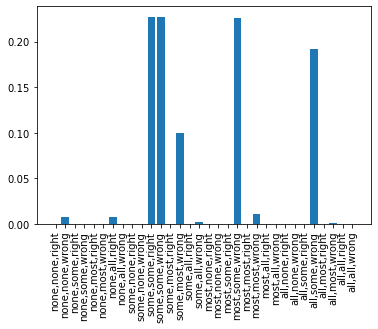

In [893]:
index_observation = 17

print(possible_observations[index_observation])

fig, ax = plt.subplots()
ax.bar(
    np.arange(len(p_utterance_given_observation[:,index_observation])), 
    p_utterance_given_observation[:,index_observation]
)
ax.set_xticks(range(32))
ax.set_xticklabels(xlabels, rotation=90)
plt.show()

# Model in PyMC3

## Prep

### Some needed objects

Calculate argumentative strengths and various needed objects.

In [765]:
raw_data, data, possible_observations, possible_utterances = functions.get_and_clean_data()

argumentative_strengths_positive = functions.calculate_argumentative_strength(
    possible_utterances, 
    possible_observations, 
    gamma_prove=0.85, 
    gamma_disprove=0.15,
    michael_method=False
)
argumentative_strengths_negative = functions.calculate_argumentative_strength(
    possible_utterances, 
    possible_observations, 
    gamma_prove=0.15,
    gamma_disprove=0.85,
    michael_method=False
)

utterance_observation_compatibility = np.stack([
    functions.verify(*a, possible_observations)
    for a in possible_utterances
])

# literal listener
p_observation_given_utterance = functions.normalize(utterance_observation_compatibility,1)
costs = functions.get_costs(possible_utterances)

8  were excluded because incompletely recorded
88  were excluded because literally false


Calculate the infodeltas and argdeltas.

In [766]:
info_deltas = functions.calculate_info_deltas(
    possible_utterances, 
    possible_observations
)
# u_o_array_to_df(
#     info_deltas, 
#     possible_observations, 
#     possible_utterances
# )[:10]

arg_deltas_negative = functions.calculate_arg_deltas(
    argumentative_strengths_negative,
    possible_observations, 
    possible_utterances
)
# u_o_array_to_df(
#     arg_deltas_negative, 
#     possible_observations, 
#     possible_utterances
# )[:10]

arg_deltas_positive = functions.calculate_arg_deltas(
    argumentative_strengths_positive,
    possible_observations, 
    possible_utterances
)
# u_o_array_to_df(
#     arg_deltas_positive, 
#     possible_observations, 
#     possible_utterances
# )[:10]

/mnt/c/Users/faust/Dropbox/Tubingen/argumentative_language/functions.py:176: RuntimeWarning: divide by zero encountered in log
  informativity = np.log(p_observation_given_utterance)


### Displaying some initial information

### Plot observation-wise data

Calculate the infodeltas and argdeltas, and the counts of
of utterances for each condition and observation combination.

In [894]:
data['infodelta'] = info_deltas[data.index_utterance, data.index_observation]
arg_deltas = np.stack((arg_deltas_negative, arg_deltas_positive))
data['argdelta'] = arg_deltas[data.condition, data.index_utterance, data.index_observation]
data_copy = data.copy()
data_copy['row_number'] = data['row_number'].apply(lambda x: '|'.join([str(i) for i in x]))
data_copy['response'] = data['response'].apply(lambda x: '|'.join([str(i) for i in x]))

counts = data_copy.value_counts().reset_index()

Display an example of counts for one observation in one condition.

In [895]:
counts[
    (counts['row_number'] =='9|9|3|3|3') &
    (counts['condition'] == 0)
]

,condition,response,row_number,trial_name,index_observation,index_utterance,mean_logliks_noconfusion,mean_logliks_confusion,infodelta,argdelta,scaled_argdelta,0
20,0,most|most|wrong,9|9|3|3|3,main_trials,0,21,-0.773847,-0.680188,0.000000,0.000000,0.000000,17
59,0,all|some|wrong,9|9|3|3|3,main_trials,0,27,-2.460816,-2.849197,0.000000,30.701587,0.583180,5
76,0,some|most|wrong,9|9|3|3|3,main_trials,0,13,-1.854687,-1.716629,0.470004,10.697294,0.203196,3
174,0,some|some|right,9|9|3|3|3,main_trials,0,10,-3.196149,-3.267391,0.641854,31.829978,0.604613,1
195,0,none|all|right,9|9|3|3|3,main_trials,0,6,-5.141037,-5.475969,0.000000,30.701587,0.583180,1


Plot for each observation/condition some information about (counts of observed in data, argdelta, etc)

In [866]:
xs, ys = np.mgrid[0:5,0:12]

for i, obs in enumerate(possible_observations):    
    
    fig, axes = plt.subplots(2,2)
    
    str_obs = '|'.join([str(a) for a in obs])
        
    subset_low = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 1)
    ][['response', 0, 'infodelta', 'argdelta', 'index_utterance']].reset_index(drop=True)
    
    subset_high = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 0)
    ][['response', 0, 'infodelta', 'argdelta', 'index_utterance']].reset_index(drop=True)
            
    axes[0,0].axis('off')
    axes[0,0].axis('tight')
    axes[0,0].table(
        cellText=subset_high.values, 
        colLabels=subset_high.columns, 
        loc='center',
        edges='vertical'
    )
    axes[0,0].set_title(
        'Low condition',
        rotation='vertical',
        x=-0.1,
        y=0.5,
        fontsize=8,
        verticalalignment='center'
    )
        
    axes[0,1].axis('off')
    axes[0,1].axis('tight')
    axes[0,1].table(
        cellText=subset_low.values,
        colLabels=subset_low.columns, 
        loc='center',
        edges='vertical'
    )
    axes[0,1].set_title(
        'High condition',
        rotation='vertical',
        x=-0.1,
        y=0.5,
        fontsize=8,
        verticalalignment='center'
    )
    
    todraw = (ys <= np.array(obs)[:,None])
    axes[1,0].imshow(todraw)
    axes[1,0].set_yticks(np.arange(5))
    axes[1,0].set_yticklabels(['Lisanne', 'Mia', 'Julia', 'Theresa', 'Julian'])
    axes[1,0].set_xticks(np.arange(13))
    axes[1,0].set_xlabel(obs)
    
    axes[1,1].axis('off')
    axes[1,1].axis('tight')

    fig.savefig(f'figs/{i}.png', dpi=300)
    plt.close(fig)

/home/fausto/anaconda3/envs/argumentative_language/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/fausto/anaconda3/envs/argumentative_language/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/fausto/anaconda3/envs/argumentative_language/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
/home/fausto/anaconda3/envs/argumentative_language/lib/python3.8/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self

### Plot scaled argdeltas

Plot the argdeltas scaled to be between 0 and 1.

In [779]:
def scale(arr, axis, upper=1):
    arr = np.where(arr==np.inf, -np.inf, arr)
    arr = arr * (upper / arr.max(axis, keepdims=True))
    return arr

In [873]:
arg_deltas = np.stack((arg_deltas_negative, arg_deltas_positive))
scaled_arg_deltas = scale(arg_deltas, 1)
data['scaled_argdelta'] = scaled_arg_deltas[
    data.condition, 
    data.index_utterance, 
    data.index_observation
]

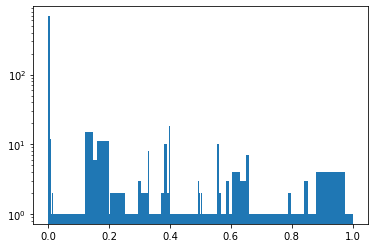

In [875]:
# Plot a histogram of the observed scaled argdeltas 
plt.hist(
    data.scaled_argdelta, 
    bins=np.unique(data.scaled_argdelta), 
    log=True,
)
plt.show()

## Basic model

In [8]:
p_observation_given_utterance.shape

(32, 20)

In [927]:
def theano_softmax(tensor, axis):
    """
    For explanations of input/outputs,
    see documentation of softmax in functions
    """
    # NOTE: axis=0 only works for 2d arrays
    if axis==1:
        return tt.nnet.softmax(tensor)
    else:
        return tt.nnet.softmax(tensor.T).T

    
def theano_normalize(tensor, axis):
    """
    For explanations of input/outputs,
    see documentation of normalize in functions
    """
    return tensor / tt.sum(tensor, axis=axis, keepdims=True)


def theano_calculate_pragmatic_speaker(argumentative_strengths,
                                p_observation_given_utterance, costs,
                                alpha, beta):
    """
    For explanations of input/outputs,
    see documentation of functions.calculate_pragmatic_speaker
    """
    p_part = p_observation_given_utterance**(alpha*beta)
    weighted_argstrength = (1-beta) * argumentative_strengths[:,None]
    unnorm_softmax = (
        p_part * tt.exp( alpha * ( weighted_argstrength - tt.shape_padright(costs) ))
    )
    p_utterance_given_observation = theano_normalize(
        unnorm_softmax, 
        axis=0
    )
    return p_utterance_given_observation


def theano_model(argumentative_strengths_positive, argumentative_strengths_negative, costs, 
                 alpha, beta, p_observation_given_utterance, data):
    
    p_utterance_given_observation_high = theano_calculate_pragmatic_speaker(
        argumentative_strengths_positive,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )

    p_utterance_given_observation_low = theano_calculate_pragmatic_speaker(
        argumentative_strengths_negative,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )

    p_utterance_given_observation = tt.stack((
        p_utterance_given_observation_low,
        p_utterance_given_observation_high
    ))

    p_production = p_utterance_given_observation[
        data.condition,
        :, 
        data.index_observation
    ]
    
    return p_production

In [768]:
mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

In [769]:
with pm.Model() as model_no_confusion:
    
    alpha = pm.Uniform(
        'alpha',
        lower=0,
        upper=5
    )
    
    beta = pm.Uniform(
        'beta',
        lower=0,
        upper=1
    )
    
    cost = pm.Exponential(
        'costnone',
        lam=0.5
    )

    costs = mask_none * cost
    
    p_production = theano_model(
        argumentative_strengths_positive, 
        argumentative_strengths_negative, 
        costs, 
        alpha, 
        beta, 
        p_observation_given_utterance, 
        data
    )
    
    utterances = pm.Categorical(
        'utterances',
        p_production,
        observed=data.index_utterance
    )
    

In [769]:
    trace_no_confusion = pm.sample(
        draws=3000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True
    )
    
    # MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [costnone, beta, alpha]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 144 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
# run with Michael's method for calculating argument strength
# i.e. considering all possible observations
az.plot_trace(trace_no_confusion)
plt.tight_layout()

RuntimeError: latex was not able to process the following string:
b'cost_none'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/home/fausto/.cache/matplotlib/tex.cache/af0576918e9204b9f4690f34e40e1d79.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty))

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/booktabs/booktabs.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
(./af0576918e9204b9f4690f34e40e1d79.aux)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\sffamily cost_
                     none}
No pages of output.
Transcript written on af0576918e9204b9f4690f34e40e1d79.log.




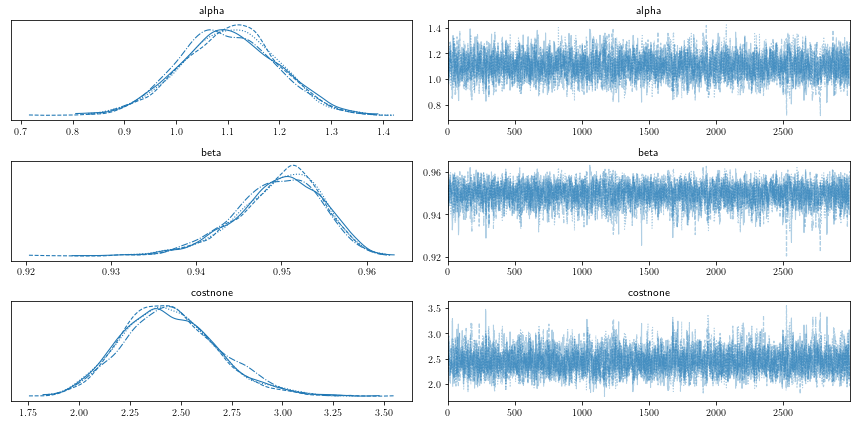

In [116]:
# run with argument strength calculated just using
# the possible observations in the experiment
az.plot_trace(trace_no_confusion)
plt.tight_layout()
plt.show()

## + agents can get condition wrong

### Model & trace

In [7]:
mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

In [770]:
with pm.Model() as model_confusion:
    
    data_utterance = pm.Data(
        'observed', 
        data['index_utterance']
    )
    
    alpha = pm.Uniform(
        'alpha',
        lower=0,
        upper=5
    )
    
    beta = pm.Uniform(
        'beta',
        lower=0,
        upper=1
    )
    
    cost = pm.Exponential(
        'costnone',
        lam=0.5
    )
    
    condition_confusion = pm.Uniform(
        'condconf',
        lower=0,
        upper=1
    )
       
    costs = mask_none * cost
    
    p_utterance_given_observation_high_pure = theano_calculate_pragmatic_speaker(
        argumentative_strengths_positive,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )

    p_utterance_given_observation_low_pure = theano_calculate_pragmatic_speaker(
        argumentative_strengths_negative,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )
    
    p_utterance_given_observation_high = (
        condition_confusion * p_utterance_given_observation_high_pure +
        (1-condition_confusion) * p_utterance_given_observation_low_pure
    )
    
    p_utterance_given_observation_low = (
        condition_confusion * p_utterance_given_observation_low_pure +
        (1-condition_confusion) * p_utterance_given_observation_high_pure
    )

    p_utterance_given_observation = tt.stack((
        p_utterance_given_observation_low,
        p_utterance_given_observation_high
    ))

    p_production = p_utterance_given_observation[
        data['condition'],
        :,
        data['index_observation']
    ]
    
    utterances = pm.Categorical(
        'utterances',
        p_production,
        observed=data_utterance
    )

In [771]:
with model_confusion:
    trace_confusion = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [condconf, costnone, beta, alpha]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 216 seconds.
The number of effective samples is smaller than 25% for some parameters.


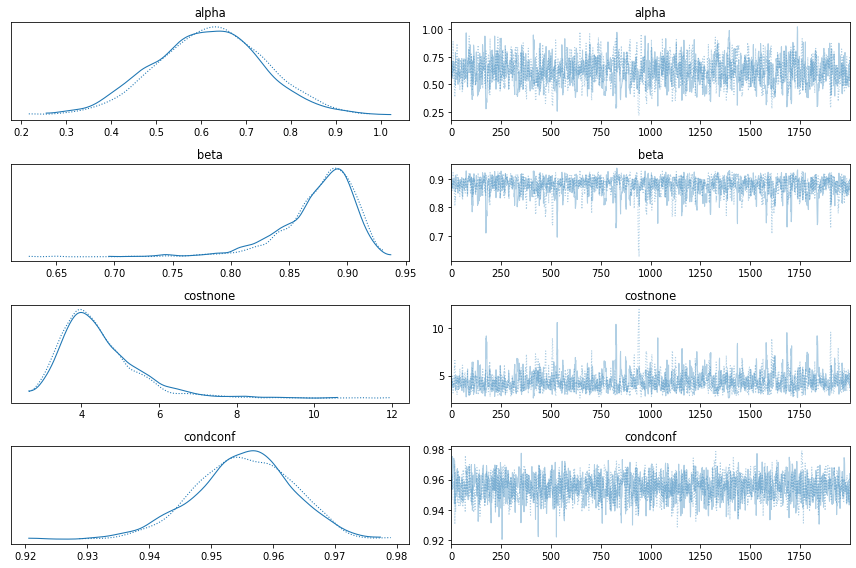

In [772]:
az.plot_trace(trace_confusion)
plt.tight_layout()
plt.show()

### Posterior predictive

In [16]:
# sample utterances in the same conditions
# as the experiment
pps = pm.sample_posterior_predictive(
    trace_confusion,
    # samples=10000,
    model=model
)

In [55]:
# contains sampled utterances for each trial
# for each trace sample.
# Each row is a simulated experiment
# the array contains the index of the produced utterance
# in each trial
pps_utterances = pps['utterances']
pps_utterances.shape

### Bayesian p-value

In [896]:
def evaluate_loglik(utterances, rowdict, model_vars):
    # change value of utterances SharedVariable
    # pymc3 Data object
    # into the utterances vector
    model_vars['data_utterance'].set_value(utterances)
    p_production = model_vars['p_production']
    return (
        tt.log(
            # probability of observing data_utterance given parameters
            p_production[tt.arange(p_production.shape[0]),data_utterance]
        )
        .sum()
        # evaluate at parameter values given by rowdict
        .eval({
            model_vars['alpha']: rowdict['alpha'],
            model_vars['beta']: rowdict['beta'],
            model_vars['cost']: rowdict['costnone'],
            model_vars['condition_confusion']: rowdict['condconf']
        })
    )


def calculate_bayesian_posterior_pvalue(trace, pps_utterances, model_vars):
    trace_vars = trace.posterior.to_dataframe().reset_index(drop=True)
    data_utterances = data.index_utterance
    at_least_as_extreme = []
    # iterate over the posterior samples for all free parameters
    for i, row in trace_vars.iterrows():
        # posterior sample of parameters        
        rowdict = row.to_dict()
        # loglikelihood of actual exp data for that trace sample
        data_evaluated_loglik = evaluate_loglik(
            data_utterances, 
            rowdict, 
            model_vars
        )
        # get posterior predictive sample of utterances
        # for that trace sample
        sim_utterances = pps_utterances[i].astype(np.int32)
        # evaluate loglikelihood of posterior sampled utterances
        sim_evaluated_loglik = evaluate_loglik(
            sim_utterances, 
            rowdict, 
            model_vars
        )
        # check if the posterior predictive sample has a likelihood
        # at least as low as that of the really observed data,
        # for that trace sample
        at_least_as_extreme.append(sim_evaluated_loglik <= data_evaluated_loglik)
        if i%100==0:
            print(len(at_least_as_extreme), end=', ')
    # give data_utterances its original value
    model_vars['data_utterance'].set_value(data_utterances)
    return at_least_as_extreme

In [55]:
model_vars = {
    'data_utterance': data_utterance,         
    'alpha': alpha,
    'beta': beta,
    'cost': cost,
    'condition_confusion': condition_confusion,
    # Theano tensor. Contains the probability of each utterance 
    # for each trial for each trace sample
    'p_production': p_production
}

at_least_as_extreme = calculate_bayesian_posterior_pvalue(
    trace_confusion, 
    pps_utterances, 
    model_vars
)

1
101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901


In [60]:
# Bayesian p-value
np.array(at_least_as_extreme).sum() / len(at_least_as_extreme)

0.5695

## + more sophisticated meaning in infostrength for 'most'

### Discussion of the model

NOTE: The code in this section can be used as a basis to write any variation of the model where the applicability of 'most' depends on a threshold that is set probabilistically.

One takeaway from looking at the counts of utterances vs their argdelta is that 'most|most' is produced more often than expected. In particular, it seems that 'most' is argumentatively stronger than expected by the model: participants choose 'most' over signals with a predicted lower argumentative strength and equal informativity. In the basic model, argumentative strength is based on the literal meaning of the utterances. Without changing the literal meanings, there isn't much room to induce different argumentative strengths. 

However, note that there is actually literature (namely, Solt's paper on 'most') that argues that 'most' conveys 'substantially above the halfpoint' as part of its literal meaning (Well, Solt doesn't say it in so many words in her paper, but Milica Denic argues that it should be taken as a semantic account). In Solt's account, the point is that 'most' protoypically exists on ordinal scales induced by the approximate number system. Therefore, only substantial differences can be perceived. This usage is then extended to even perceptually precise cases of 'most' via typicality. So the idea is to use Solt's version of meaning of 'most'.

More technically:
- Can use the cdf of a beta distribution rescaled between 0.5 and 1 as the underlying 'semantic compatibility'.
- Since we can assume (going with Solt) that the confidence increases going up from 0.5, we can constrain $\alpha = 1$ and $\beta \geq 1$ (this restriction also turns out to be useful below).
- In the Solt sense this can be interpreted as the probability that the number will be 'distinguished' from the halfpoint.
- Can also be thought of as the probability of the 'true threshold' being below each point (although Solt might not agree with this interpretation).
- There are in practice 4 possible thresholds for the occurrence of 'most' (0, 3, 9, 12) and 6 for the outer occurrence (0, 1, 2, 3, 4, 5). 
- What the Solt account tells us is the probability of each combination of thresholds for the outer and inner occurrence of 'most'. I am assuming they are determined independently. Conceptually: The 'discrimination' from the midpoint has to happen independently for the two 'spaces'.
- I follow the following steps (Note: here be dragons): 
    - First, I calculate whether each observation satisfies each signal (including the ones that do not contain most) for each possible combination of thresholds of inner and outer 'most' (NOTE: this passage can be pre-computed).
    - Then, I calculate the probability of the threshold falling between each possible threshold and the previous, e.g. in the inner 'most' case: [0,3], [3,9], [9,12]. 
        - This gives the probability of being in each 'threshold-situation'.
        - These probabilities can be used to calculate 'truth-value expectations', which conceptually are the probabilities of thresholds being set in such a way that an observation verifies a signal.
        - This is the substantial step, conceptually.
        - The cdf of a beta distribution is the regularized incomplete beta function $I_x(a,b)$, which is a messy function. But conveniently, if we fix $a=1$ it has a nice closed form: $I_x(1,b) = 1 - (1-x)^b$.
        - Here we need to calculate cdf(higher threshold)-cdf(lower threshold). This becomes $I_{h}(1,b) - I_{l}(1,b) = 1 - (1-h)^b - (1 - (1-l)^b) = (1-l)^b - (1-h)^b$. This is numerically more stable than calculating it with cdfs directly. This could be approximated (see [this thread](https://math.stackexchange.com/questions/2241239/generalized-differences-of-powers)) but it looks like it doesn't really have problems numerically until really high values of $\beta$, which are going to be excluded by the prior anyway.
    - Then, I calculate the expected truth value of each signal for each observation, across every combination of thresholds for inner and outer 'most'.
- Example: 'All of the students got all of the questions right'
    - `[12, 0, 0, 0, 0]`: This will always be false across all set combinations of thresholds for inner and outer 'most'. Its expected value is 0.
    - `[12, 12, 12, 12, 12]`: This will always be true, and therefore its expected value is 1.
- Example: 'Some of the students got all of the questions right':
    - `[12, 12, 3, 3, 3]`: This will always be true because 'most' does not appear in the utterance.
- Example: 'Some of the students got most of the questions right':
    - `[9, 9, 3, 3, 3]`: This will be true if 9 is distinguished from the midpoint (in this case 6). The probability of this happening depends on the $\beta$ parameter of the Beta distribution.

### Precompute values in numpy and numpy tests

In [8]:
def beta_interval_explicit(array, beta):
    midpoint = array.max()/2
    cdfs = stats.beta.cdf(
        (array - midpoint) / midpoint, 
        a=1, 
        b=beta
    )
    probs = cdfs[1:] - cdfs[:-1]
    return np.concatenate(([0], probs))

def beta_interval(array, beta):
    """
    Parameters
    ----------
    array: array
        An array of possible thresholds
    beta: float
        Beta parameter for the 
    """
    midpoint = array.max()/2
    arr_temp = (array - midpoint) / midpoint
    arr_useful = arr_temp * (arr_temp >= 0).astype(int)
    probs = (1-arr_useful[:-1])**beta - (1-arr_useful[1:])**beta
    return np.concatenate(([0], probs))

In [349]:
# check that the two ways of calculating the array are close
np.allclose(beta_interval(np.arange(10), 1000), beta_interval_explicit(np.arange(10), 1000))

True

Start by precomputing everything that doesn't need to be computed in Theano.

In [9]:
# add wrong and right
# Dimensions: (predicate, observation, student)
# contains # of answers that verify the predicate
possible_situations_pred = np.stack(
    (possible_observations, 12-possible_observations),
    axis=0
)

most_internal = np.tile(possible_situations_pred[None], (4,1,1,1))

# For each possible num of answers that could count as 'most', 
# find whether each student in each observation answered
# at least that many questions right or wrong (depending on predicate)
# Dimensions: (possible thresholds, predicate, observations, student)
# Note: the probability of accepting 'most' as applying to 
# a certain number of answers in an observation is the probability of accepting
# the lowest number in the observations.
which_threshold = most_internal >= np.array([0, 3, 9, 12])[:,None,None,None]

# Shape: (4, 4, 2, 20, 5)
# dimensions (internal quant, possible thresholds for 'most', adjective, observation, student).
# It contains the truth of each innerquant+adj for each observation
# for each interpretation of 'most'
possible_situations_internal = np.stack(
    (
        # none
        np.tile(possible_situations_pred == 0, (4,1,1,1)),
        # some
        np.tile(possible_situations_pred > 1, (4,1,1,1)),
        # most
        which_threshold,
        # all
        np.tile(possible_situations_pred == 12, (4,1,1,1))
    ),
    axis=0
)

# for each possible fixed threshold for inner 'most'
# how many students count as having answered
# '___ of the questions ___'
# Dimensions: (internal quant, threshold inner most, adj, observation)
# Shape: (4, 4, 2, 20, 5)
external_counts = possible_situations_internal.sum(-1)

# For each possible threshold for 
# 'most' for the # of students and for the # of answers,
# whether 'most of the students got __ of the answers __' is true
# for each observation
# Dimensions: (threshold for outer 'most', internal quant, threshold for inner 'most', adj, obs)
# Shape: (6, 4, 4, 2, 20)
external_counts_tiled = np.tile(external_counts[None], (6,1,1,1,1))
most_external = (
    external_counts_tiled >= 
    np.arange(6)[:,None,None,None,None]
)

# Dimensions: (outer quant, threshold outer 'most', inner quant, threshold inner 'most', adj, obs)
# Shape: (4, 6, 4, 4, 2, 20)
# Note: technically the threshold for outer 'most' only influences outer 'most',
# so I could pre-calculate it just for outer most and remove that dimension from this array.
# However, it seems worth keeping the more general case here in case we end up 
# adding other signals with variable thresholds.
possible_situations_external = np.stack(
    (
        # none
        external_counts_tiled == 0,
        # some
        external_counts_tiled > 0,
        # most 
        most_external,
        # all
        external_counts_tiled == 5
    ),
    axis=0
)

As a test, calculate for a specific value of most_precision (i.e. the beta parameter) what needs to be computed later in theano:

In [10]:
# the higher most_precision, the higher the acceptability
# of observations right above 0.5
# most_precision goes from 0 to inf
most_precision = 0
    
# the probability of ending up with
# each of the four thresholds
# for inner 'most'
# Shape: (4,)
counts_12 = beta_interval(np.array([0, 3, 9, 12]), most_precision+1)

# the probability of ending up with each
# of the possible thresholds for outer 'most'
# i.e. six num of students (0,1,2,3,4,5)
# Shape: (6,)
counts_5 = beta_interval(np.arange(6), most_precision+1)

# # for each number of questions answered right|wrong in each
# # observation, the probability that 'most' applies to that number
# # Shape: (4, 6, 4, 4, 2, 20)
# p_most_applies = which_threshold.astype(int) * counts_12[:,None,None,None]

# Shape: (4, 6, 4, 4, 2, 20)
p_internal_most = possible_situations_external * counts_12[:, None, None]

p_thresholds_most = p_internal_most * counts_5[:,None,None,None,None]

# Dimensions: (signals, obs)
# Shape: (32,20)
# Effectively, this replaces utterance_observation_compatibility
graded_truth_values = p_thresholds_most.sum((1,3)).reshape(-1, 20)

In [375]:
# display the whole array for visual checks 
# Everything seems to make sense!
functions.u_o_array_to_df(graded_truth_values, possible_observations, possible_utterances)

,[9 9 3 3 3],[12 12 0 0 0],[12 12 12 12 12],[9 9 0 0 0],[12 12 9 0 0],[12 12 12 9 9],[12 12 12 0 0],[9 9 9 3 3],[9 9 9 9 9],[3 3 3 0 0],[12 12 3 0 0],[12 12 12 3 3],[12 12 3 3 3],[0 0 0 0 0],[3 3 3 3 3],[12 12 9 3 3],[12 12 9 9 9],[3 3 0 0 0],[9 9 9 0 0],[9 9 3 0 0]
none|none|right,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
none|none|wrong,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
none|some|right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
none|some|wrong,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
none|most|right,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.5,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.5,0.5
none|most|wrong,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.5,1.0,0.0,0.0,0.5,0.5,0.0,0.5,0.5,1.0,0.0,0.0,0.0
none|all|right,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
none|all|wrong,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
some|none|right,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
some|none|wrong,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


### Theano implementation and PyMC3 fitting

In [925]:
def print_value_theano(value, wrt):
    tt.printing.Print('value')(
        value.flatten()
    )
    tt.printing.Print('grad')(
        tt.jacobian(value.flatten(), wrt)
    )


def theano_beta_interval(array, beta):
    """
    Parameters
    ----------
    array: array
        A  array of possible thresholds
    beta: theano float
        Beta parameter for the distribution over thresholds for 'most'
    
    Returns
    -------
    theano tensor:
        The probability mass contained between the intervals in array
    """
    return (1-array[:-1])**beta - (1-array[1:])**beta


def theano_calculate_graded_truth_values(beta, which_threshold, possible_situations_external):
    # this is for threshold array np.array([0, 3, 9, 12])
    # counts_12 says to what extent each number counts as 12 under the 
    # 'most' threshold distribution
    # NOTE: I add a zero at the beginning of the first argument of theano_beta_interval
    # so that the the first element of the returned value gives the probability
    # from 0 to the first actual possible observation
    # here 0.5 stays for 9 and 1. stays for 12
    counts_12_probs = theano_beta_interval(np.array([0., 0.5, 1.]), beta)
    counts_12 = tt.concatenate(([0.,0.],counts_12_probs))
    
    # this is for threshold array np.arange(6)
    counts_5_probs = theano_beta_interval(np.array([0., 0.2, 0.6, 1.]), beta)
    counts_5 = tt.concatenate(([0.,0.,0.],counts_5_probs))
    
    ###### NOTE: here the gradient was breaking because of the 0s.
    # In order to not break the gradient here,
    # it is important to not have the gradient 
    # on a 0 that is later taken to the power of a number <1.
    # A switch doesn't work (somehow PyMC3 refuses to just forget
    # that some nan gradients were involved even if they are
    # switched out)
    # I tried various things but it's tricky to fix.
    # So I took the easy way out and substituted 0s by a small constant.
    counts_12 = tt.switch(
        tt.eq(counts_12,0), 
        1e-20, 
        counts_12
    )
    counts_5 = tt.switch(
        tt.eq(counts_5,0), 
        1e-20, 
        counts_5
    )

    p_thresholds_most  = (
        np.where(possible_situations_external, 1, 1e-20) *
        counts_12[:,None,None] * 
        counts_5[:,None,None,None,None]
    )

    graded_truth_values = p_thresholds_most.sum((1,3)).reshape((-1, 20))
    return graded_truth_values


def theano_calculate_p_utterance_given_gamma(possible_observations, graded_truth_values, gamma):
    p_obs_given_gamma = (
        stats.binom.pmf(
            possible_observations, 
            n=12, 
            p=gamma
        )
        .prod(-1)[None]
    )
    return (p_obs_given_gamma * graded_truth_values).sum(1)


def theano_calculate_argumentative_strength(possible_observations, graded_truth_values,
                                            gamma_prove=0.85, gamma_disprove=0.15):
    return (
            tt.log(theano_calculate_p_utterance_given_gamma(
                possible_observations, 
                graded_truth_values,
                gamma_prove
            )) -
            tt.log(theano_calculate_p_utterance_given_gamma(
                possible_observations, 
                graded_truth_values, 
                gamma_disprove
            ))
        )


def theano_calculate_pragmatic_speaker(argumentative_strengths,
                                p_observation_given_utterance, costs,
                                alpha, beta):
    
    p_part = p_observation_given_utterance**(alpha*beta)
    # only different from the above is that argumentative strength
    # now is a theano tensor, and therefore
    # I use shape_padright instead of None
    weighted_argstrength = (1-beta) * tt.shape_padright(argumentative_strengths)
    
    unnorm_softmax = (
        p_part * tt.exp( alpha * ( weighted_argstrength - tt.shape_padright(costs) ))
    )
    p_utterance_given_observation = theano_normalize(
        unnorm_softmax, 
        axis=0
    )

    return p_utterance_given_observation

In [782]:
mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

with pm.Model() as model_solt:
    
    data_utterance = pm.Data(
        'observed', 
        data['index_utterance']
    )
    
    ##### priors
    
    alpha = pm.Exponential(
        'alpha',
        lam=1.
    )
    
    cost = pm.Exponential(
        'costnone',
        lam=0.5
    )
    
    most_precision = pm.Exponential(
        'most_precision',
        lam=0.5,
    )
    
    beta = pm.Uniform(
        'beta',
        lower=0,
        upper=1
    )
    
    condition_confusion = pm.Uniform(
        'condconf',
        lower=0,
        upper=1
    )
    
    ##### likelihood
        
    costs = mask_none * cost
    
    graded_truth_values = theano_calculate_graded_truth_values(
        most_precision+1, 
        # precomputed
        which_threshold,
        # precomputed
        possible_situations_external
    )
        
    argumentative_strengths_positive = theano_calculate_argumentative_strength(
        possible_observations, 
        graded_truth_values,
        gamma_prove=0.85, 
        gamma_disprove=0.15,
    )
    
    argumentative_strengths_negative = theano_calculate_argumentative_strength(
        possible_observations, 
        graded_truth_values,
        gamma_prove=0.15,
        gamma_disprove=0.85,
    )
    
    p_observation_given_utterance = functions.normalize(
        graded_truth_values,
        1
    )
        
    p_utterance_given_observation_high_pure = theano_calculate_pragmatic_speaker(
        argumentative_strengths_positive,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )

    p_utterance_given_observation_low_pure = theano_calculate_pragmatic_speaker(
        argumentative_strengths_negative,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )
    
    p_utterance_given_observation_high = (
        condition_confusion * p_utterance_given_observation_high_pure +
        (1-condition_confusion) * p_utterance_given_observation_low_pure
    )
    
    p_utterance_given_observation_low = (
        condition_confusion * p_utterance_given_observation_low_pure +
        (1-condition_confusion) * p_utterance_given_observation_high_pure
    )

    p_utterance_given_observation = tt.stack((
        p_utterance_given_observation_low,
        p_utterance_given_observation_high
    ))

    p_production = p_utterance_given_observation[
        data['condition'],
        :,
        data['index_observation']
    ]
    
    utterances = pm.Categorical(
        'utterances',
        p_production,
        observed=data_utterance,
        # shape=len(data.index_utterance)
    )

In [783]:
with model_solt:
    trace_solt = pm.sample(
        draws=5000,
        tune=5000,
        chains=4,
        target_accept=0.95,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [condconf, beta, most_precision, costnone, alpha]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 327 seconds.


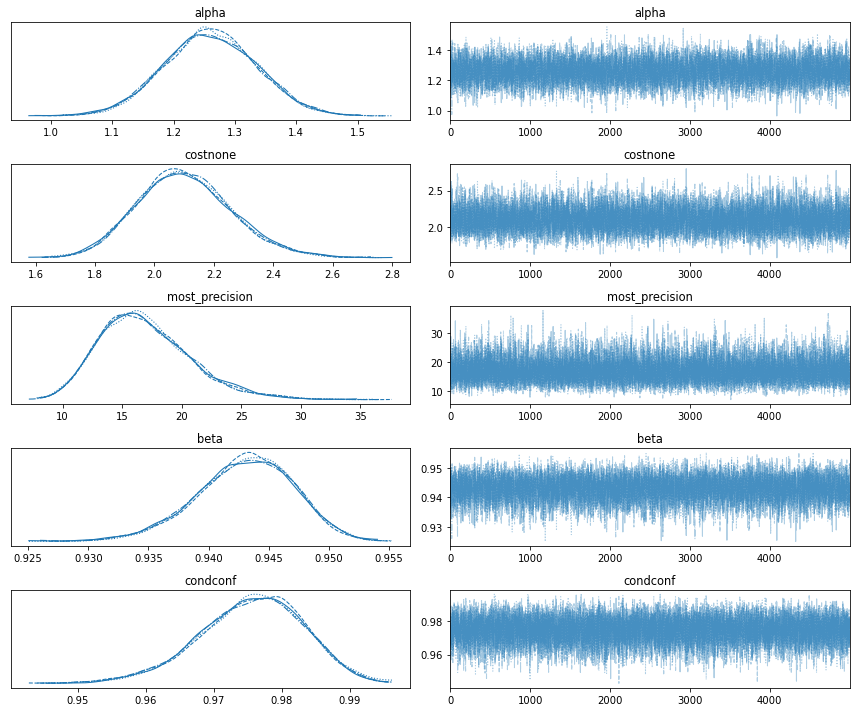

In [784]:
az.plot_trace(trace_solt)
plt.tight_layout()

### Posterior predictive checks

In [786]:
with model_solt:
    pps_solt = pm.sample_posterior_predictive(trace_solt)

In [793]:
pps_solt_u = pps_solt['utterances']

In [817]:
pps_solt_df = pd.DataFrame(
    pps_solt_u,
    columns=pd.MultiIndex.from_frame(data[['index_observation', 'condition']])
)

In [906]:
# counts of utterance production across all 
# posterior samples for each combination of 
# observation and condition
pps_solt_counts = pd.melt(pps_solt_df).value_counts(subset=['index_observation', 'condition', 'value']).reset_index()

In [908]:
# add a human readable column with the utterances, rather
# than just having the indices.
pps_solt_counts['utts'] = ['|'.join(i) for i in possible_utterances[pps_solt_counts['value'].values]]

In [910]:
for o in range(20):
    
    pps_counts_pos = pps_solt_counts[
        (pps_solt_counts['condition']==1) & 
        (pps_solt_counts['index_observation']==o)
    ].reset_index(drop=True)
    pps_counts_pos['props'] = pps_counts_pos[0] / pps_counts_pos[0].sum()
    
    print(possible_observations[o])
        
    pps_counts_neg = pps_solt_counts[
        (pps_solt_counts['condition']==0) & 
        (pps_solt_counts['index_observation']==o)
    ].reset_index()
    pps_counts_neg['props'] = pps_counts_neg[0] / pps_counts_neg[0].sum()
    
    print(pps_counts_pos)

[9 9 3 3 3]
    index_observation  condition  value       0             utts     props
0                   0          1     12  181338  some|most|right  0.348727
1                   0          1     26   76433   all|some|right  0.146987
2                   0          1     27   66773   all|some|wrong  0.128410
3                   0          1     18   42703  most|some|right  0.082121
4                   0          1     19   40172  most|some|wrong  0.077254
5                   0          1     10   33760  some|some|right  0.064923
6                   0          1     11   32785  some|some|wrong  0.063048
7                   0          1     21   14723  most|most|wrong  0.028313
8                   0          1     13   10846  some|most|wrong  0.020858
9                   0          1      0    5506  none|none|right  0.010588
10                  0          1      7    5475   none|all|wrong  0.010529
11                  0          1      1    4830  none|none|wrong  0.009288
12           

### Trying to fix the broken gradient

Here are some disorganized notes from attempts at fixing the gradient problem (keeping for future reference, they aren't meant to be read!)

In [69]:
with model_solt:
    samples = pm.sample_prior_predictive()

In [70]:
samples = {i:k for i,k in samples.items() if ('log' not in i) and ('interval' not in i)}

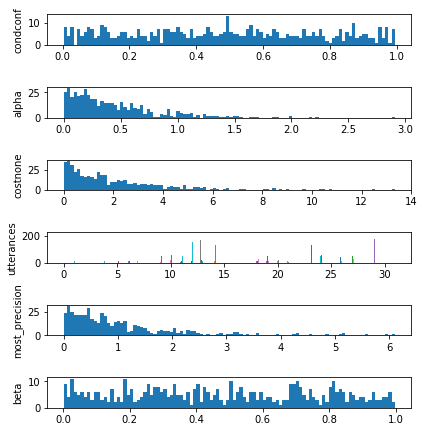

In [71]:
fig, axes = plt.subplots(len(samples.keys()), figsize=(6,6))
for i, (key, value) in enumerate(samples.items()):
    axes[i].hist(value, 100)
    axes[i].set_ylabel(key)
plt.tight_layout()
plt.show()

In [18]:
# d_alpha, d_beta, d_cost, d_condition_confusion, 
d_most_precision = tt.jacobian(
    p_production.flatten(), most_precision
)

In [22]:
evaldict = {
    alpha: 1.2, 
    beta: 0.8, 
    cost: 2, 
    condition_confusion: 0.94, 
    most_precision: 1.5
}

In [ ]:
evaldict = {
    'most_precision': , 
    'condconf_interval__': , 
    'alpha_log__': , 
    'beta_interval__': , 
    'costnone_log__': 
}

In [20]:
model_solt.test_point

{'alpha_log__': array(0.32663426),
 'beta_interval__': array(0.),
 'costnone_log__': array(0.32663426),
 'condconf_interval__': array(0.),
 'most_precision_log__': array(-0.36651292)}

In [29]:
np.isnan(d_most_precision.eval(evaldict)).any()

MissingInputError: Input 5 of the graph (indices start from 0), used to compute for{cpu,scan_fn}(Subtensor{int64}.0, Subtensor{:int64:}.0, Subtensor{int64}.0, Reshape{1}.0, most_precision, condconf_interval__, alpha_log__, beta_interval__, costnone_log__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [26]:
T.exception_verbosity='high'

In [441]:
d_alpha.eval(evaldict)

array([-3.22180963e-03,  0.00000000e+00,  0.00000000e+00, ...,
       -3.26725877e-05,  0.00000000e+00,  1.56083525e-02])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c0d78c8e0>,
      dtype=object)

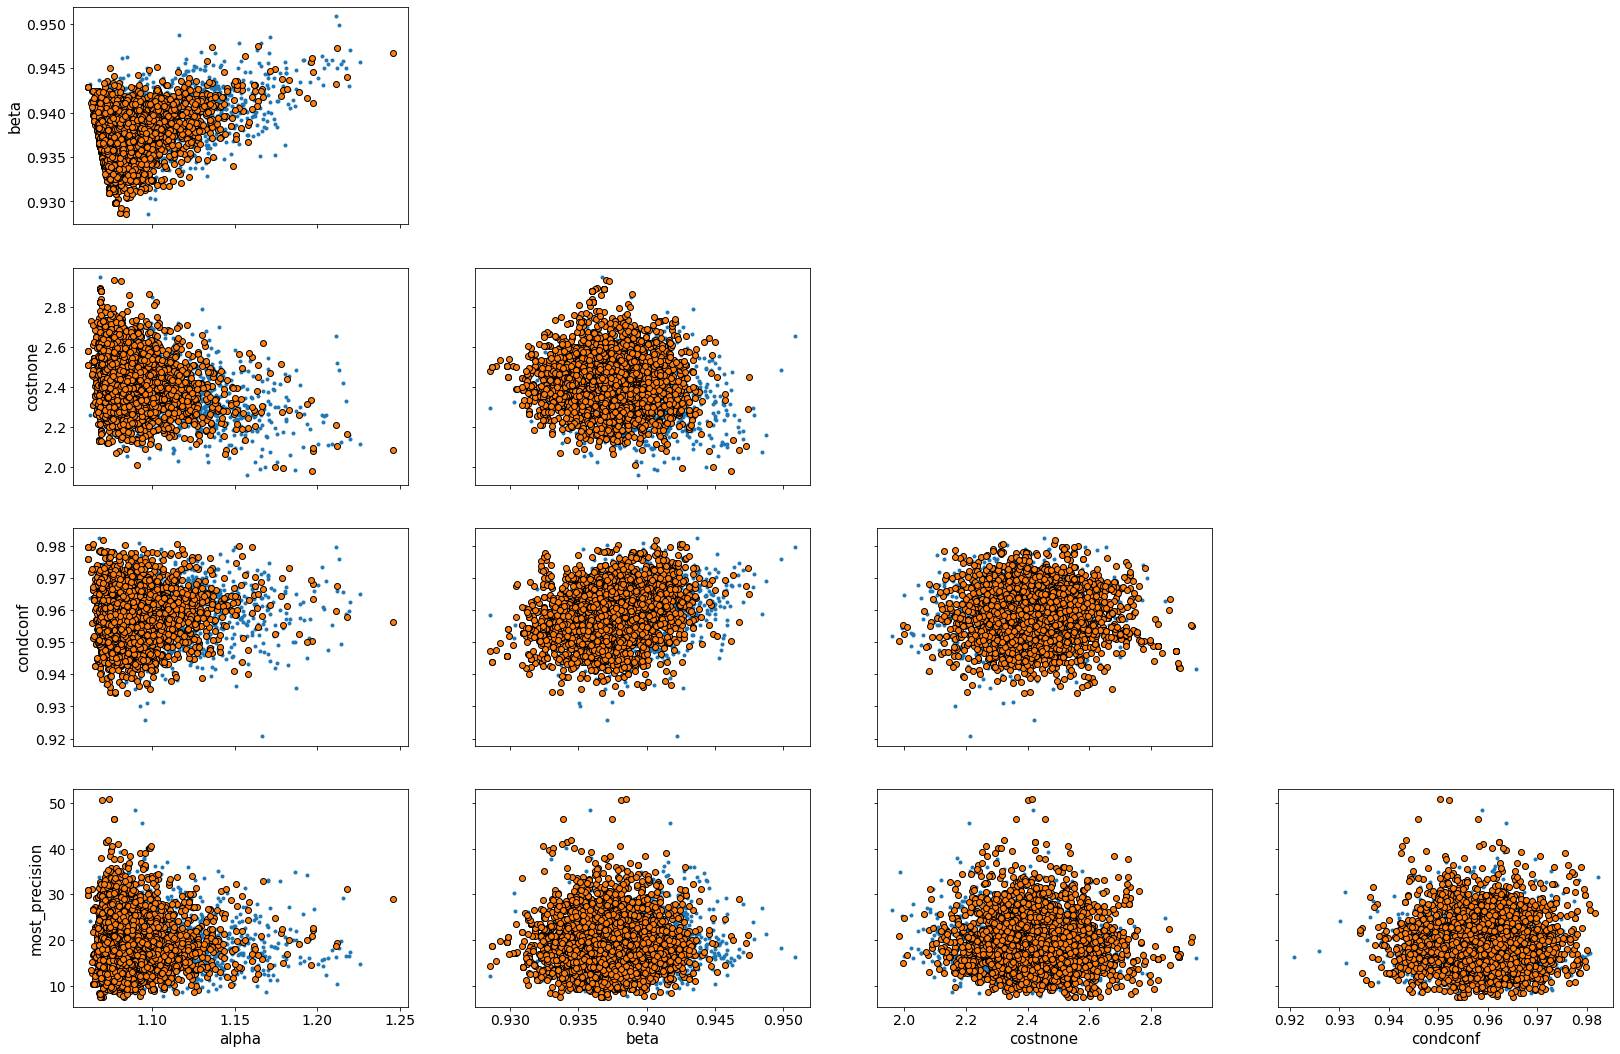

In [429]:
az.plot_pair(trace_solt, divergences=True)

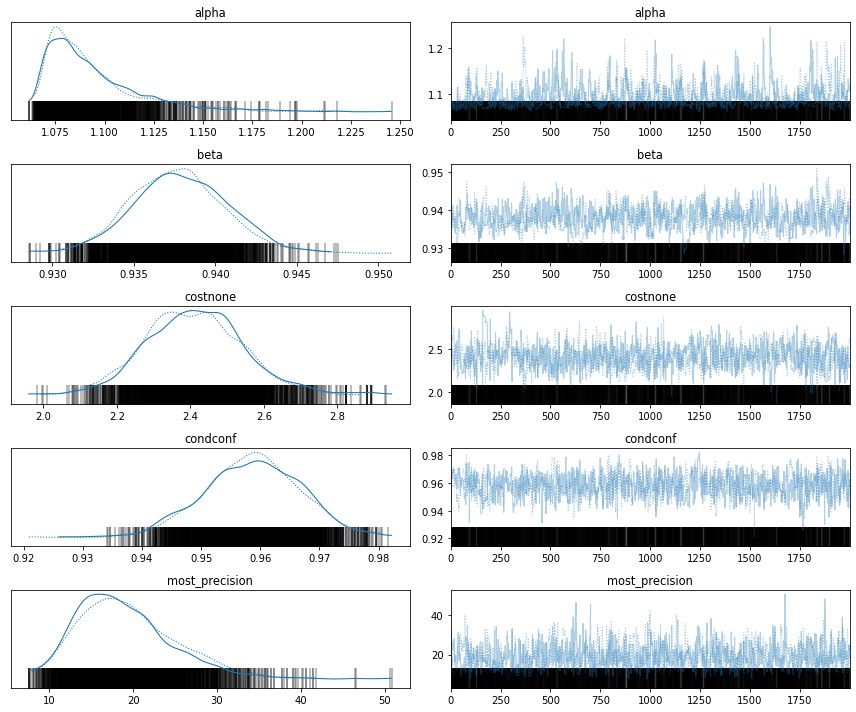

In [427]:
az.plot_trace(trace_solt)
plt.tight_layout()
plt.show()

In [740]:
def print_value_theano(value, wrt):
    tt.printing.Print('value')(
        value
    )
    tt.printing.Print('grad')(
        tt.jacobian(value.flatten(), wrt)
    )
    print('\n')


with pm.Model() as model_test:
    
    beta = pm.Exponential(
        'beta',
        lam=0.5,
        testval=0.5
    )
    
    value = tt.concatenate(([0.], np.array([0.5, 0.8])*beta))
    # The gradient of this is all NAN!!
    print_value_theano(
        value**0.9, 
        beta
    )
    
    value = np.array([0., 0.5, 0.8])*beta
    print_value_theano(
        value**0.9, 
        beta
    )
    
    arr = np.array([0., 0.5, 0.8])
    value = tt.switch(arr>0, arr*beta,0)
    print_value_theano(
        value**0.9, 
        beta
    )
    
    probs = value**0.9
    probs = probs / probs.sum()
    
    obs = pm.Categorical('obs', probs, observed=[1])
    
    trace = pm.sample()

value __str__ = [0.         0.28717459 0.43838329]
grad __str__ = [0.         0.51691426 0.78908992]


value __str__ = [0.         0.28717459 0.43838329]
grad __str__ = [nan nan nan]


value __str__ = [0.         0.28717459 0.43838329]
grad __str__ = [0.         0.51691426 0.78908992]




/tmp/ipykernel_1614/2743480237.py:44: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## + pragmatic meaning for 'most' (UNFINISHED!)

It is plausible that given the non-cooperative setup of the experiment, participants are in fact thinking about the argumentative effects of the pragmatic interpretation of their utterances. In this perspective, it is more plausible that 'most' has stronger argumentative force than predicted by the basic model. If we model prag argstrength, there are two natural options:
- 'Most' has a stronger argstrength than in the basic model
- All other signals convey something weaker than predicted by the basic model.

Parameterize the information conveyed by 'most'. 
- How to do it?
- I want it, depending on the parameter value, to be able to:
    1) Be unimodal at any point in the (0.5, 1] interval
    2) Be more or less uniform
    3) Of course, be discrete
- The binomial is capable of (1) but not (2)
- Maybe a beta-binomial?
    - The beta-binomial is capable of both (1) and (2), it is discrete, and conveniently parameterized by the number of bernoulli trials (as we want), and by $\alpha$ and $\beta$.
    - We can add the restriction that 'most' pragmatically encodes a unimodal distribution
    - In other words, we can assume 'most' does not convey that 'either close to 0.5 or close to 1.0'
    - The beta-binomial is multimodal when both $\alpha$ and $\beta$ are < 1.
    - So the strategy would be: put a linear bound on the joint prior over $[\alpha, \beta]$ so that $\alpha + \beta > 1$
    - Simple possible solution: reparameterize in terms of (1) $\alpha + \beta$, and (2) $\alpha$, and put a lower bounded prior on the former.
        - In this parameterization, is there an okay looking vague prior? 

In [87]:
reload(functions)

<module 'functions' from '/mnt/c/Users/faust/Dropbox/Tubingen/argumentative_language/functions.py'>

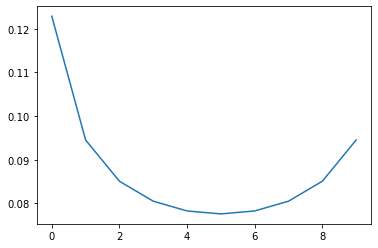

In [88]:
n = 10
xs = np.arange(n)
mu = 0.5
rho = 0.4
ys = functions.beta_binomial_pmf(
    mu, 
    rho, 
    n
)
plt.plot(xs, ys)
plt.show()

In [ ]:
def calculate_pragmatic_p_utterance_given_state_theano(mu_most, rho_most, but_not_all):
    """
    This function can be used both to calculate the pragmatic speaker and to calculate
    pragmatic argumentative strength.
    """
    
    # Create an array with shape (# utterances, # observations)
    # with the pragmatic p(state | utterance) (i.e. the approximated pragmatic speaker)
    # basically it's the same as the literal one except for utterances containing 'most' or 'some'
    
    # Normalize by state to get p(utterance | state) (i.e. approximated pragmatic listener)
    

In [89]:
mu, rho = 0.5, 0.5
logp_betabinom = pm.BetaBinomial.dist(
    n=7,
    alpha=functions.calculate_alpha(mu, rho),
    beta=functions.calculate_beta(mu, rho)
).logp(np.arange(6)).eval()

In [90]:
logp_betabinom

array([-1.56316207, -2.18220128, -2.38287197, -2.45983301, -2.45983301,
       -2.38287197])

In [91]:
mu, rho = 0.3, 0.7
np.exp(pm.BetaBinomial.dist(
    n=12,
    alpha=functions.calculate_alpha(mu, rho),
    beta=functions.calculate_beta(mu, rho)
).logp(possible_observations).eval())

array([[0.02586546, 0.02586546, 0.03156471, 0.03156471, 0.03156471],
       [0.13486386, 0.13486386, 0.50282394, 0.50282394, 0.50282394],
       [0.13486386, 0.13486386, 0.13486386, 0.13486386, 0.13486386],
       [0.02586546, 0.02586546, 0.50282394, 0.50282394, 0.50282394],
       [0.13486386, 0.13486386, 0.02586546, 0.50282394, 0.50282394],
       [0.13486386, 0.13486386, 0.13486386, 0.02586546, 0.02586546],
       [0.13486386, 0.13486386, 0.13486386, 0.50282394, 0.50282394],
       [0.02586546, 0.02586546, 0.02586546, 0.03156471, 0.03156471],
       [0.02586546, 0.02586546, 0.02586546, 0.02586546, 0.02586546],
       [0.03156471, 0.03156471, 0.03156471, 0.50282394, 0.50282394],
       [0.13486386, 0.13486386, 0.03156471, 0.50282394, 0.50282394],
       [0.13486386, 0.13486386, 0.13486386, 0.03156471, 0.03156471],
       [0.13486386, 0.13486386, 0.03156471, 0.03156471, 0.03156471],
       [0.50282394, 0.50282394, 0.50282394, 0.50282394, 0.50282394],
       [0.03156471, 0.03156471, 0.

In [92]:
possible_observations.shape

(20, 5)

In [93]:
possible_observations[None,None,None].shape

(1, 1, 1, 20, 5)

- Build a 4x4x2x5 array, with dimensions representing:
    - external quantifier (size 4)
        - none, some, most, all 
        - In that order!
    - internal quantifier (size 4)
    - predicate (size 2)
    - observation (size 20)
    - student (size 5)
- Each element of the array is initially the number of correct answer given by the student

In [94]:
possible_situations = possible_observations.copy()

# add wrong and right
# dimensions: (predicate, observation, student)
# contains # of answers that verify the predicate
possible_situations_pred = np.stack(
    (possible_situations, 12-possible_situations),
    axis=0
)

In [95]:
possible_situations_pred

array([[[ 9,  9,  3,  3,  3],
        [12, 12,  0,  0,  0],
        [12, 12, 12, 12, 12],
        [ 9,  9,  0,  0,  0],
        [12, 12,  9,  0,  0],
        [12, 12, 12,  9,  9],
        [12, 12, 12,  0,  0],
        [ 9,  9,  9,  3,  3],
        [ 9,  9,  9,  9,  9],
        [ 3,  3,  3,  0,  0],
        [12, 12,  3,  0,  0],
        [12, 12, 12,  3,  3],
        [12, 12,  3,  3,  3],
        [ 0,  0,  0,  0,  0],
        [ 3,  3,  3,  3,  3],
        [12, 12,  9,  3,  3],
        [12, 12,  9,  9,  9],
        [ 3,  3,  0,  0,  0],
        [ 9,  9,  9,  0,  0],
        [ 9,  9,  3,  0,  0]],

       [[ 3,  3,  9,  9,  9],
        [ 0,  0, 12, 12, 12],
        [ 0,  0,  0,  0,  0],
        [ 3,  3, 12, 12, 12],
        [ 0,  0,  3, 12, 12],
        [ 0,  0,  0,  3,  3],
        [ 0,  0,  0, 12, 12],
        [ 3,  3,  3,  9,  9],
        [ 3,  3,  3,  3,  3],
        [ 9,  9,  9, 12, 12],
        [ 0,  0,  9, 12, 12],
        [ 0,  0,  0,  9,  9],
        [ 0,  0,  9,  9,  9],
        

In [96]:
weight_somebutnotall = 0.1

In [310]:
# probability of applying internal quantifier
possible_situations_internal = np.stack(
    (
        # none
        possible_situations_pred == 0,
        # some
        np.where(
            possible_situations_pred==12, 
            weight_somebutnotall, 
            (1-weight_somebutnotall)/2
        ) * (possible_situations_pred != 0).astype(int),
        # most (NOTE: uses the fact that negative numbers have prob 0)
        stats.betabinom.pmf(possible_situations_pred-7, n=5, a=alpha, b=beta),
        # all
        possible_situations_pred == 12
    ),
    axis=0
)

In [576]:
possible_situations_internal = (
    possible_situations_internal / 
    possible_situations_internal.sum((2,3),keepdims=True)
)

In [577]:
possible_situations_internal

array([[[[0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.05      , 0.03636364, 0.03636364],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.05      , 0.03636364, 0.03636364],
         [0.        , 0.        , 0.        , 0.03636364, 0.03636364],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.03636364, 0.03636364],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.03636364, 0.03636364],
         [0.        , 0.        , 0.        , 0.03636364, 0.03636364],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.03636364, 0.03636364, 0.05      , 0.03636364, 0.03636364],
      

- Now calculate the probability of applying external quantifier.
- `possible_situations_internal` records the probability of the internal quantifier+predicate being applied to each answer by each student. 
- Let's say that the external quantifier is a function of: in how many of the student-answer combo the internal quantifier + predicate are applied. 
    - Suppose for instance that `possible_situations_pred` is `[ 9,  9,  3,  3,  3]`, and therefore `possible_situations_internal` is `[0.16677502, 0.16677502, 0., 0., 0.]` at "the students got some answers right" (first quantifier is still unspecified).
    - Then, there is a probability 0.16677502 that 'some answers right' is applied to the first student (9), 0.16677502 * 0.16677502 that it is applied to the first AND second student, and so forth. 
    - So how many students the outer quantifier is applied to is stochastic (for 'some' and 'all'), and to know the probability I have to consider the powerset of students. There are 2^5-1 = 31 possible combinations (empty set always has probability 0).
    - In sum, any combination of the answers can happen, with a probability that depends on the product of their probabilities
- Once I have the probability that  each inner quant + predicate

In [524]:
from itertools import chain, combinations

def calculate_powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [567]:
possible_situations_internal.shape

(4, 2, 20, 5)

In [580]:
possible_situations_internal.sum((2,3))

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [581]:
# powerset contains each combination of observations that can be accepted
# including when none of the observations are accepted
powerset = list(calculate_powerset(np.arange(5)))

_,_,_,index_answer = np.indices(possible_situations_internal.shape)

# mask_combinations_answers gives a mask for each combination of observations
mask_combinations_answers = np.array([
    np.in1d(index_answer,np.array(p))
    for p in powerset
]).reshape(32, *index_answer.shape)

# probability for each of the 31 combinations of observed numbers of correct answers by the students
# that the combination of internal quantifier + predicate is applied to it
p_combinations = np.where(
    mask_combinations_answers,
    np.tile(possible_situations_internal, (32,1,1,1,1)),
    1
).prod(-1)

# additionally: if none of the quantifiers are applicable to a certain
# combination, that combination has probability 0
p_combinations = p_combinations * np.all(possible_situations_internal!=0, axis=-1)[None].astype(int)

# this gives for each combination the number of observations 
# accepted in that combination
n_combinations_accepted = np.array([len(a) for a in powerset])

# repeat p_combination for number from 0 to 5
# representing the number of observations that 
# the utterance was used for
tiled_p_combinations = np.tile(
    p_combinations[None], 
    reps=(6,1,1,1,1)
)

# says for each number from 1 to 5
# which elements of n_combinations_accepted
# refer to that many observations
tosum = (np.unique(n_combinations_accepted)[:,None] == n_combinations_accepted)

# p_number_true gives for each number n of observations
# the probability that the number of observations in the first dimension (0 to 5)
# are accepted by the inner_quantifier+predicate in each situation.
p_number_true = np.where(
    tosum[:,:,None,None,None],
    tiled_p_combinations,
    0
).sum(1)

## + without giving arbitrary values to $\gamma$ (Discussion - maths to double check)

In the current model, the argument strength depends on the probability of a certain utterance counting as true given a *specific value of the binomial parameter*, marginalized across states. 
- However, it seems more likely that the argument is saying something more general, namely something like "the binomial parameter is _high_ [_low_]", encoding something like "the students are _good_ [_bad_]". 
- Note that in this case 'high' [_low_] need not mean e.g. $>0.5$ [$<0.5$]. There is some unknown threshold $\theta_{\text{high}}$ [$\theta_{\text{low}}$] such that the participant is arguing that the binomial parameter is at least as large [at least as small] as that threshold.
- Also, note that $\theta_{\text{high}}$ is probably not equal to 1-$\theta_{\text{low}}$. 
    - This depends on the type of question: if the questions are binary and a random guesser guesses right half of the times on average, both the threshold for 'bad' and for 'good' are probably higher than 0.5! 
    - On the other hand, if there are many answers for each question the threshold for good might be at 0.5.
    - The fact that people didn't seem to really need this information to answer consistently perhaps suggests that they were using more of an ordering of utterances.
- Question: Is it possible to estimate $\theta$ from the data?
- For the high condition:

\begin{align}
\log \frac{p \left( u \mid \gamma \geq \theta_{\text{high}} \right) }{ p \left( u \mid \gamma < \theta_{\text{high}} \right) } 
&= \log \frac{
\sum_{i=1}^{20} p \left( u \mid o_i \right) p \left( o_i \mid \gamma \geq \theta_{\text{high}} \right) 
}{ 
\sum_{i=1}^{20} p \left( u \mid o_i \right) p \left( o_i \mid \gamma < \theta_{\text{high}} \right) 
} \\
&= \log \frac{
\sum_{i=1}^{20} p \left( u \mid o_i \right) \int_{\theta_{\text{high}}}^1 p \left( o_i \mid \gamma = x \right) dx 
}{ 
\sum_{i=1}^{20} p \left( u \mid o_i \right)  \int_0^{\theta_{\text{high}}} p \left( o_i \mid \gamma = x \right) dx 
} \\
&= \log \frac{
\sum_{i=1}^{20} p \left( u \mid o_i \right) \int_{\theta_{\text{high}}}^1 \frac{1}{K(x)} \prod_{j=1}^5 \phi_{\text{Binom}} ( \#_j^i ; p= x, n = 12 ) dx 
}{ 
\sum_{i=1}^{20} p \left( u \mid o_i \right)  \int_0^{\theta_{\text{high}}} \frac{1}{K(x)} \prod_{j=1}^5 \phi_{\text{Binom}} ( \#_j^i ; p= x, n = 12 ) dx  
} \\
\end{align}

where $\#_j^i$ is the number of correct answers by student $j$ in observation $i$ and $K(x,i)$ is a normalization factor for the actual observations (rather than all possible binomial ones):
$$
K(x) = \sum_{h=1}^{20} \prod_{j=1}^5 \phi_{\text{Binom}} ( \#_j^h ; p= x, n = 12 )
$$

And $p(u \mid o)$ is the truth value (possibly graded).

Note that
$$
\prod_{i=1}^5 \phi_{\text{Binom}} ( m_i ; p=x, n=12 ) = p^{\sum_{j=1}^{5} m_j} (1-p)^{5 \times 12 - \sum_{j=1}^{5} m_j} \prod_{j=1}^{5} \binom{12}{m_j}
$$

- The whole thing doesn't look very promising in terms of fitting the $\theta$s from the data. It would need to be done within Theano because of the integration.
- If we want to only consider the observations possible in the experiment:
    - Another, simpler option: 
        1. Compute values numerically for a bunch of points
        1. Approximate the curve with a polynomial or some other function that's easy to work with in Theano.
        1. Use the approximation instead.
    - Yet another option: 
        1. Give a plausible value to $\theta_{\text{high}}$ and $\theta_{\text{low}}$ based on previous literature (e.g. on gradable adjectives).
        2. In this case we can precompute the value of the above for each observation very precisely and just use those pre-computed values.

Alternatively, we can consider _all possible observations_.
- Each student can answer in $2^{12}$ possibly ways, and there are 5 students that give answers, for a total of $4096^5$ many ($2^{12^5}$) possible observations. Let's call this rather large number $L$.
- The calculation above becomes simpler:

\begin{align}
\log \frac{p \left( u \mid \gamma \geq \theta_{\text{high}} \right) }{ p \left( u \mid \gamma < \theta_{\text{high}} \right) } 
&= \log \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) \int_{\theta_{\text{high}}}^1 \prod_{j=1}^5 \phi_{\text{Binom}} ( \#_j^i ; p= x, n = 12 ) dx 
}{ 
\sum_{i=1}^L p \left( u \mid o_i \right)  \int_0^{\theta_{\text{high}}} \prod_{j=1}^5 \phi_{\text{Binom}} ( \#_j^i ; p= x, n = 12 ) dx  
} \\
&= \log \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) \int_{\theta_{\text{high}}}^1 x^{\sum_{j=1}^{5} \#_j^i} (1-x)^{5 \times 12 - \sum_{j=1}^{5} \#_j^i} \prod_{j=1}^{5} \binom{12}{\#_j^i} dx 
}{ 
\sum_{i=1}^L p \left( u \mid o_i \right)  \int_0^{\theta_{\text{high}}} x^{\sum_{j=1}^{5} \#_j^i} (1-x)^{5 \times 12 - \sum_{j=1}^{5} \#_j^i} \prod_{j=1}^{5} \binom{12}{\#_j^i} dx  
} \\
\end{align}

Let's write $z_j^i = \sum_{j=1}^{5} \#_j^i$. Then the above becomes (note the movement of the $dx$):

\begin{align}
\log \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) \int_{\theta_{\text{high}}}^1 x^{z_j^i} (1-x)^{5 \times 12 - z_j^i} dx \prod_{j=1}^{5} \binom{12}{\#_j^i}
}{ 
\sum_{i=1}^L p \left( u \mid o_i \right) \int_0^{\theta_{\text{high}}} x^{z_j^i} (1-x)^{5 \times 12 - z_j^i} dx  \prod_{j=1}^{5} \binom{12}{\#_j^i}
} \\
\end{align}

And by sheer luck the integral becomes a known Chebyshev integral:

$$
\int x^{z_j^i} (1-x)^{5 \times 12 - z_j^i} dx = B(x ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i)
$$

where $B$ is our friend the incomplete beta function.
- Note: the _regularized_ incomplete beta function, which is the cdf of the Beta distribution, is equal to the incomplete Beta function divided by $B(a,b)$.
- Theano doesn't have the incomplete beta function, but it has the (log) regularized incomplete Beta function in terms of the logcdf of the Beta (recently implemented!).
- Therefore to get a differentiable incomplete beta function we can just take the logcdf of the Beta distribution with Theano and multiply it by the precomputed values of the beta function for the relevant $a$ and $b$s. 

The whole thing simplifies to:
\begin{align}
\log \frac{p \left( u \mid \gamma \geq \theta_{\text{high}} \right) }{ p \left( u \mid \gamma < \theta_{\text{high}} \right) } 
&= \log \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} \left( B(1 ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) - B(\theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) \right)
}{ 
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} \left( B( \theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) - B(0 ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) \right)
} \\
&= \log \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} \left( B(1 ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) - B(\theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) \right)
}{ 
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} B( \theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i)
} \\
&= \log \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} B(1 ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) - \sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} B(\theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i)
}{ 
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} B( \theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i)
} \\
&= \log \left( \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} B(1 ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i) 
}{
\sum_{i=1}^L p \left( u \mid o_i \right) \prod_{j=1}^{5} \binom{12}{\#_j^i} B( \theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i)
}
- 1 \right)
\end{align}

and finally, since the regularized Beta at 1 is just the Beta, it becomes:

\begin{align}
\log \frac{p \left( u \mid \gamma \geq \theta_{\text{high}} \right) }{ p \left( u \mid \gamma < \theta_{\text{high}} \right) } 
&= 
\log \left( \frac{
\sum_{i=1}^L p \left( u \mid o_i \right) B(1 + z_j^i, 61 - z_j^i) \prod_{j=1}^{5} \binom{12}{\#_j^i} 
}{
\sum_{i=1}^L p \left( u \mid o_i \right) B( \theta_{\text{high}} ; 1 + z_j^i, 61 - z_j^i)  \prod_{j=1}^{5} \binom{12}{\#_j^i} 
}
- 1 \right)
\end{align}

which is about as much as I managed to simplify it, and it means that we can precalculate everything except for $B( \theta_{\text{high}} ; 1 + z_j^i, 1 + 5 \times 12 - z_j^i)$. 
- The question now is whether that can be done by theano in a reasonable time for such a large number of points.
- However note that the involved terms are all insensitive to the order of the answers / of the students:
    - $p \left( u \mid o_i \right)$: All the quantifiers we have satisfy permutation invariance. So if two observations have the same number of each number of right answers, they'll get the same truth value for a quantifier.
    - $z_j^i = \sum_{j=1}^{5} \#_j^i$: $z_j^i$ is only sensitive to the total number of correct answers across all students, and therefore there's only $12 \times 5 = 60$ distinct values.
    - $\prod_{j=1}^{5} \binom{12}{\#_j^i}$: like $p \left( u \mid o_i \right)$, this is not sensitive to the order of the answers within each student, but it is sensitive to the number of students with each number of correct answers. E.g. $\binom{12}{2} \binom{12}{2} = 4356$ is different from $\binom{12}{3} \binom{12}{1} = 2640$.

So the last remaining question to make everything calculable is how to find the numbers by which to multiply each value of $\prod_{j=1}^{5} \binom{12}{\#_j^i}$ and $p \left( u \mid o_i \right)$. 
- Create a table of every unique way of attributing a total of 5 to the numbers from 0 to 12 (representing the number of students who got each number of questions right). It'll look like this (where each row sums to 5):

| 0   | 1   | 2   | ... | 12  |
| --- | --- | --- | --- | --- |
| 5   | 0   | 0   | ... | 0   |
| 0   | 5   | 0   | ... | 0   |
| ... | ... | ... | ... | ... |
| 1   | 2   | 1   | ... | 0   |
| 0   | 4   | 1   | ... | 0   |

- So each row is one possible scenario when we abstract from the order of the participants and of the questions, but we keep how many participants got how many questions right.
- The number of observations within a row can be calculated as:
$$
\sum_{i=0}^{12} \binom{12}{i}^{k_i}
$$
where $k_i$ is the number in the table for that row/column combo (i.e. the number of participants that got that number of questions right).
- The big summation over $L$ above can be substituted by a summation over the rows of this table, where each summand is multiplied by the number of observations within that row.

## + argumentative strengths calculated with S1

This is the same as the basic model, but instead of calculating the argumentative strength with the truth value, we calculate it with the pragmatic production probabilities. 
- To see the conceptual connection, note that the original argstrength can be rewritten in terms of the probability of making an observation and the probability of a signal being true given the observation:

\begin{align}
\text{argstrength}(u) 
&= \log \frac{
p(u \mid \gamma = 0.85)
}{
p(u \mid \gamma = 0.15)
} \\
&= \log \frac{
\sum_{i=1}^{20} p(u, o_i \mid \gamma = 0.85)
}{
\sum_{i=1}^{20} p(u, o_i \mid \gamma = 0.15)
} \\
&= \log \frac{
\sum_{i=1}^{20} p( u \mid o_i) p(o_i, \gamma = 0.85)
}{
\sum_{i=1}^{20} p( u \mid o_i) p(o_i, \gamma = 0.15)
} \\
&= \log \frac{
\sum_{o \in u} p(o, \gamma = 0.85)
}{
\sum_{o \in u} p(o, \gamma = 0.15)
} \\
\end{align}

But now instead of considering the probability that an utterance is true, consider the probability of the literal speaker producing an utterance given an observation. 

\begin{align}
\text{argstrength}(u) 
&= \log \frac{
p(u \mid \gamma = 0.85)
}{
p(u \mid \gamma = 0.15)
} \\
&= \log \frac{
\sum_{i=1}^{20} p(u, o_i \mid \gamma = 0.85)
}{
\sum_{i=1}^{20} p(u, o_i \mid \gamma = 0.15)
} \\
&= \log \frac{
\sum_{i=1}^{20} p( u \mid o_i) p(o_i, \gamma = 0.85)
}{
\sum_{i=1}^{20} p( u \mid o_i) p(o_i, \gamma = 0.15)
} \\
&= \log \frac{
\sum_{i=1}^{20} p(o_i, \gamma = 0.85) 
\begin{cases}
\frac{1}{| u |} & \text{if } o \in u \\
0               & \text{else}
\end{cases}
}{
\sum_{i=1}^{20} p(o_i, \gamma = 0.15)
\begin{cases}
\frac{1}{| u |} & \text{if } o \in u \\
0               & \text{else}
\end{cases}
} \\
&= \log \frac{
\sum_{o \in u} p(o, \gamma = 0.85) \frac{1}{| u |} 
}{
\sum_{o \in u} p(o, \gamma = 0.15) \frac{1}{| u |} 
} \\
&= \log \frac{
\frac{1}{| u |} \sum_{o \in u} p(o, \gamma = 0.85) 
}{
\frac{1}{| u |} \sum_{o \in u} p(o, \gamma = 0.15) 
} \\
&= \log \frac{
\sum_{o \in u} p(o, \gamma = 0.85) 
}{
\sum_{o \in u} p(o, \gamma = 0.15) 
} \\
\end{align}

It's the same!

- So the argumentative strength above was basically the Bayes factor calculated by the listener using the literal speaker as a model.
- Instead of the literal speaker, a pragmatic speaker can be used. 
    - This pragmatic speaker is different from the real pragmatic speaker, because they do not include argument strength in their calculation, corresponding to the idea that the real speaker is imagining a listener who doesn't take into account the speaker's argumentative aims.
    - Nonetheless, I always assume a literal listener with a uniform prior over states (Is this reasonable?)
    - Conceptually, a pragmatic speaker that uses this type of argumentative strength relies on (\ exploits) the listener's assumption of cooperativeness. 
- In this case, there are three differences:
    - 'some' implicates 'not most'
    - 'some' implicates 'not all'
    - 'most' implicates 'not all'
- The other signals do not generate implicatures.

In [934]:
def theano_calculate_p_observation_given_gamma(possible_observations, gamma):
    p_obs_given_gamma = (
        stats.binom.pmf(
            possible_observations, 
            n=12, 
            p=gamma
        )
        .prod(-1)[None]
    )
    return p_obs_given_gamma / p_obs_given_gamma.sum()


def theano_simple_prag_speaker(p_observation_given_utterance, alpha, costs):
    p_part = p_observation_given_utterance**alpha    
    softmax = theano_normalize(
        p_part * tt.exp( - alpha * tt.shape_padright(costs) ),
        axis=0
    )
    return softmax


def theano_calculate_pragmatic_argstrength(possible_utterances, possible_observations,
                                           gamma_prove, gamma_disprove, alpha):
    
    utterance_observation_compatibility = np.stack([
        functions.verify(*a, possible_observations)
        for a in possible_utterances
    ])
    
    # probability of each observation given gammas
    p_obs_prove = theano_calculate_p_observation_given_gamma(
        possible_observations, 
        gamma_prove
    )
    p_obs_disprove = theano_calculate_p_observation_given_gamma(
        possible_observations, 
        gamma_disprove
    )
    
    # literal listener
    p_observation_given_utterance = functions.normalize(
        utterance_observation_compatibility,
        1
    )
    
    # pragmatic speaker
    # who assumes a literal listener with a uniform
    # prior over states.
    pragmatic_speaker = theano_simple_prag_speaker(
        p_observation_given_utterance, 
        alpha, 
        costs
    )
    
    return (
        tt.log((pragmatic_speaker * p_obs_prove).sum(1)) -
        tt.log((pragmatic_speaker * p_obs_disprove).sum(1))
    )


def theano_calculate_pragmatic_speaker(argumentative_strengths,
                                p_observation_given_utterance, costs,
                                alpha, beta):
    
    p_part = p_observation_given_utterance**(alpha*beta)
    weighted_argstrength = (1-beta) * tt.shape_padright(argumentative_strengths)
    
    unnorm_softmax = (
        p_part * tt.exp( alpha * ( weighted_argstrength - tt.shape_padright(costs) ))
    )
    p_utterance_given_observation = theano_normalize(
        unnorm_softmax, 
        axis=0
    )

    return p_utterance_given_observation

In [930]:
mask_none = np.any(possible_utterances=='none', axis=1).astype(int)

In [935]:
with pm.Model() as model_pragargstrength:
    
    data_utterance = pm.Data(
        'observed', 
        data['index_utterance']
    )
    
    alpha = pm.Uniform(
        'alpha',
        lower=0,
        upper=5
    )
    
    beta = pm.Uniform(
        'beta',
        lower=0,
        upper=1
    )
    
    cost = pm.Exponential(
        'costnone',
        lam=0.5
    )
    
    condition_confusion = pm.Uniform(
        'condconf',
        lower=0,
        upper=1
    )
       
    costs = mask_none * cost
    
    argumentative_strengths_positive = theano_calculate_pragmatic_argstrength(
        possible_utterances, 
        possible_observations,
        gamma_prove=0.85, 
        gamma_disprove=0.15,
        alpha=alpha
    )
    
    argumentative_strengths_negative = theano_calculate_pragmatic_argstrength(
        possible_utterances, 
        possible_observations,
        gamma_prove=0.15, 
        gamma_disprove=0.85,
        alpha=alpha
    )
    
    p_utterance_given_observation_high_pure = theano_calculate_pragmatic_speaker(
        argumentative_strengths_positive,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )

    p_utterance_given_observation_low_pure = theano_calculate_pragmatic_speaker(
        argumentative_strengths_negative,
        p_observation_given_utterance, 
        costs,
        alpha, 
        beta
    )
    
    p_utterance_given_observation_high = (
        condition_confusion * p_utterance_given_observation_high_pure +
        (1-condition_confusion) * p_utterance_given_observation_low_pure
    )
    
    p_utterance_given_observation_low = (
        condition_confusion * p_utterance_given_observation_low_pure +
        (1-condition_confusion) * p_utterance_given_observation_high_pure
    )

    p_utterance_given_observation = tt.stack((
        p_utterance_given_observation_low,
        p_utterance_given_observation_high
    ))

    p_production = p_utterance_given_observation[
        data['condition'],
        :,
        data['index_observation']
    ]
    
    utterances = pm.Categorical(
        'utterances',
        p_production,
        observed=data_utterance
    )

In [937]:
with model_pragargstrength:
    trace_pragargstrength = pm.sample(
        draws=3000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True
    )
    
    # MAP = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [condconf, costnone, beta, alpha]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 666 seconds.
The number of effective samples is smaller than 25% for some parameters.


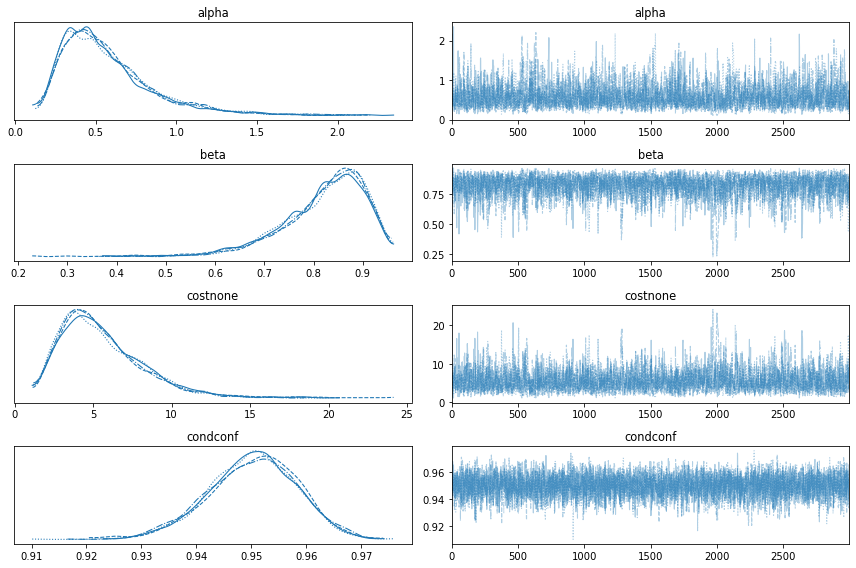

In [939]:
az.plot_trace(trace_pragargstrength)
plt.tight_layout()

# Compare models

## LOO comparison

In [949]:
loo = az.compare({
    'tracenoconf': trace_no_confusion,
    'traceconf': trace_confusion,
    'tracesolt': trace_solt,
    'trace_pragargstrength': trace_pragargstrength
})

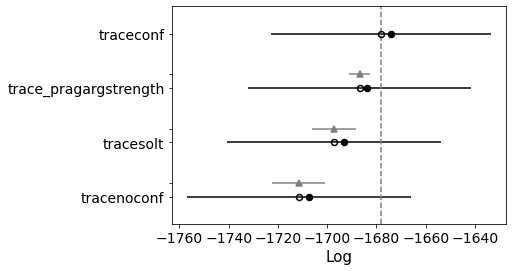

In [950]:
az.plot_compare(loo)
plt.show()

## Compare loglikelihoods by individual observation

### Basic model vs model with condition confusion

Calculate the mean posterior loglikelihood of each datapoint:

In [775]:
logliks = trace_no_confusion.log_likelihood.utterances.data.reshape(-1, 1104)
data['mean_logliks_noconfusion'] = logliks.mean(0)

logliks = trace_confusion.log_likelihood.utterances.data.reshape(-1, 1104)
data['mean_logliks_confusion'] = logliks.mean(0)

Look at the observations with the highest and lowest likelihood for the model with confusion (and their likelihood for the model without confusion) (NOTE: positive values mean that the basic model is better than the model with condition confusion):

In [940]:
data.sort_values(by='mean_logliks_confusion')[
    ['condition', 'response', 'row_number', 'mean_logliks_noconfusion', 'mean_logliks_confusion']
]

,condition,response,row_number,mean_logliks_noconfusion,mean_logliks_confusion
280,0,"[none, all, right]","[9, 9, 0, 0, 0]",-7.306930,-7.170969
562,1,"[none, all, wrong]","[12, 12, 12, 12, 12]",-10.931184,-6.873029
1199,1,"[some, none, right]","[0, 0, 0, 0, 0]",-6.052405,-6.782241
773,0,"[none, all, wrong]","[3, 3, 3, 3, 3]",-6.887352,-6.696194
1104,0,"[none, all, right]","[3, 3, 3, 0, 0]",-6.919871,-6.668751
...,...,...,...,...,...
164,0,"[all, all, wrong]","[0, 0, 0, 0, 0]",-0.170037,-0.217774
926,0,"[all, all, wrong]","[0, 0, 0, 0, 0]",-0.170037,-0.217774
236,0,"[all, all, wrong]","[0, 0, 0, 0, 0]",-0.170037,-0.217774
12,0,"[all, all, wrong]","[0, 0, 0, 0, 0]",-0.170037,-0.217774


Consider the same values but summed for each combination of condition, observation, and utterance:

In [944]:
data.groupby(['condition', 'index_observation', 'index_utterance']).sum().filter(like='mean_')

mean_logliks_noconfusion  \
condition index_observation index_utterance                             
0         0                 6                               -5.141037   
                            10                              -3.196149   
                            13                              -5.564062   
                            21                             -13.155395   
                            27                             -12.304082   
...                                                               ...   
1         18                27                              -2.474774   
          19                10                              -2.411278   
                            12                             -16.308923   
                            13                              -3.392184   
                            18                             -17.720672   

                                             mean_logliks_confusion  
condition index_observation index_utterance                          
0         0                 6                             -5.475969  
                            10                            -3.267391  
                            13                            -5.149886  
                            21                           -11.563197  
                            27                           -14.245983  
...                                                             ...  
1         18                27                            -2.978982  
          19                10                            -2.448432  
                            12                           -12.564611  
                            13                            -3.732214  
                            18                           -18.671725  

[207 rows x 2 columns]

The distribution of delta logliks (shown below) tells us that the model with condition confusion actually fits the data worst than the basic model for most cases, and does _a lot better_ in a few cases. Presumably this is because mostly participants understood which condition they were in and gave appropriate answers - and in these cases the basic model does better - however, when they did not their behaviour is seriously puzzling for the basic model.
- HYPOTHESIS: The model with condition confusion will fit the data substantially better with confusion fitted by participant.
- With hierarchical confusion parameter, the participants who did the experiment right can get low confusion probability and be fitted properly, while the ones who didn't understand the design immediately can be recognized as such.

In [917]:
data['delta_meanloglik_confusion_noconfusion'] = data.mean_logliks_noconfusion - data.mean_logliks_confusion

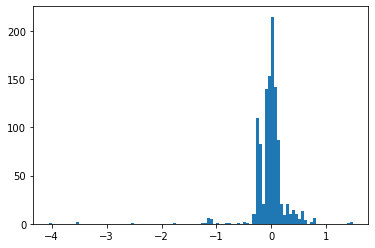

In [948]:
plt.hist(data['delta_meanloglik_confusion_noconfusion'], 100)
plt.show()

Question: for which observation does the model which assumes a possible confusion of condition do better than the model which assumes that participants always know what they are arguing for?

Answer:

In [924]:
data.sort_values(by='delta_meanloglik_confusion_noconfusion')[
    [c for c in data.columns if c not in 
     ['trial_name', 'index_observation', 'index_utterance', 'infodelta', 'argdelta', 'scaled_argdelta']
    ]
]

,condition,response,row_number,mean_logliks_noconfusion,mean_logliks_confusion,delta_meanloglik_confusion_noconfusion
562,1,"[none, all, wrong]","[12, 12, 12, 12, 12]",-10.931184,-6.873029,-4.058155
208,0,"[some, all, right]","[12, 12, 0, 0, 0]",-6.960606,-3.424063,-3.536543
1126,0,"[some, all, right]","[12, 12, 0, 0, 0]",-6.960606,-3.424063,-3.536543
221,0,"[some, most, right]","[9, 9, 0, 0, 0]",-6.325503,-3.776615,-2.548887
451,1,"[most, all, wrong]","[12, 12, 0, 0, 0]",-5.157675,-3.380238,-1.777437
...,...,...,...,...,...,...
474,0,"[most, most, right]","[12, 12, 12, 3, 3]",-3.389230,-4.182746,0.793516
797,1,"[most, most, wrong]","[9, 9, 0, 0, 0]",-3.389230,-4.182746,0.793516
54,0,"[all, most, right]","[12, 12, 12, 12, 12]",-3.032722,-4.454376,1.421654
665,1,"[most, all, wrong]","[0, 0, 0, 0, 0]",-3.551312,-5.037661,1.486349


Note that this is what you'd expect:
- The model with confusion is better than the one without confusion e.g. for utterance 'none of the students got all of the questions wrong' in the high condition. 
- This is a strange answer for the high condition, because there is an obvious alternative answer 'all of the students got all of the answers right', which is a lot better from an argumentative strength point of view.

However, something more interesting is going on with the utterances that the basic model can fit better than the model with confusion.
- They all seem to contain most! 
- What is up with that?

### Condition confusion vs Solt meaning for 'most' 

TODO

# Various notes

In [201]:
# loglikelihood of the actual data for each posterior sample
# note that it's different from logp because it doesn't contain the 
# prior probabilities
np.log(trace['p_production'][:,np.arange(len(data.index_utterance)), data.index_utterance]).sum(-1)

array([-1676.36421022, -1678.47800857, -1678.81668517, ...,
       -1677.00140539, -1674.58699388, -1676.26964299])

In [189]:
lnp

array([-1685.19091354, -1687.10316049, -1687.3766244 , ...,
       -1685.75812891, -1683.56619218, -1685.37353507])

In [136]:
# indices of trials where observation 0 was observed
indices_observation_zero = np.argwhere(
    (data['index_observation'] == 0).values
    # & (data['condition'] == 0).values
).flatten()
# posterior sample utterances at those trials
observations_zero = pps_utterances.T[indices_observation_zero]
# unique and counts of those utterances
unique, counts = np.unique(observations_zero, return_counts=True)

In [137]:
np.column_stack((possible_utterances[unique], counts))

array([['none', 'none', 'right', '1276'],
       ['none', 'none', 'wrong', '1211'],
       ['none', 'all', 'right', '1192'],
       ['none', 'all', 'wrong', '1302'],
       ['some', 'some', 'right', '11957'],
       ['some', 'some', 'wrong', '11969'],
       ['some', 'most', 'right', '41953'],
       ['some', 'most', 'wrong', '22238'],
       ['most', 'some', 'right', '13498'],
       ['most', 'some', 'wrong', '12909'],
       ['most', 'most', 'wrong', '58118'],
       ['all', 'some', 'right', '17560'],
       ['all', 'some', 'wrong', '16817']], dtype='<U21')

In [138]:
pp_df = pd.DataFrame(pps_utterances.T)

In [139]:
pp_df['index_observation'] = data.index_observation
pp_df['condition'] = data.condition

In [140]:
# each column is a full simulated experiment
# the values are the indices of the produced utterances
pp_df

,0,1,2,3,4,5,6,7,8,9,...,3992,3993,3994,3995,3996,3997,3998,3999,index_observation,condition
0,25,30,30,30,30,30,30,25,30,3,...,30,3,30,30,30,30,30,30,2,1
1,23,23,23,23,23,15,23,23,23,16,...,23,15,23,23,15,21,23,23,3,0
2,12,12,27,27,19,12,12,26,10,12,...,18,26,12,27,13,26,12,27,0,1
3,15,15,15,15,15,15,12,13,15,13,...,15,15,10,15,15,15,15,10,4,0
4,18,26,18,26,11,18,10,11,10,26,...,10,10,11,10,7,18,26,26,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,14,14,10,14,14,14,14,14,14,14,...,12,11,14,14,23,14,14,14,1,1
1100,23,23,15,23,23,23,23,23,23,23,...,15,23,15,15,15,23,23,23,3,0
1101,27,13,29,11,10,18,11,18,21,18,...,19,19,19,19,18,27,18,15,9,1
1102,21,21,21,21,21,13,21,21,21,11,...,13,19,21,21,12,21,13,19,0,0


In [141]:
(pp_df[pp_df.index_observation==0].iloc[:,:-2] == 14).sum().sum()

0

In [142]:
flattened_pp_df = pp_df.melt(id_vars=['index_observation', 'condition'])

In [143]:
flattened_pp_df

,index_observation,condition,variable,value
0,2,1,0,25
1,3,0,0,23
2,0,1,0,12
3,4,0,0,15
4,5,0,0,18
...,...,...,...,...
4415995,1,1,3999,14
4415996,3,0,3999,23
4415997,9,1,3999,15
4415998,0,0,3999,19


In [144]:
(flattened_pp_df[flattened_pp_df.index_observation==0].value.values==14).sum()

0

In [145]:
pp_df_counts = flattened_pp_df.pivot_table(index=['index_observation', 'condition'], columns='value', aggfunc='count')
pp_df_counts = pp_df_counts.fillna(0)

In [146]:
pp_df_counts

variable                                          \
value                             0       1       2       3       4       5    
index_observation condition                                                    
0                 0            389.0   446.0     0.0     0.0     0.0     0.0   
                  1            887.0   765.0     0.0     0.0     0.0     0.0   
1                 0              0.0     0.0     0.0     0.0     0.0     0.0   
                  1              0.0     0.0     0.0     0.0     0.0     0.0   
2                 0           2153.0     0.0     0.0   271.0     0.0    91.0   
                  1            127.0     0.0     0.0  6854.0     0.0    82.0   
3                 0              0.0    95.0     0.0     0.0     0.0     0.0   
                  1              0.0  1013.0     0.0     0.0     0.0     0.0   
4                 0              0.0     0.0     0.0     0.0     0.0     0.0   
                  1              0.0     0.0     0.0     0.0     0.0     0.0   
5                 0           2211.0     0.0     0.0     0.0     0.0   219.0   
                  1            117.0     0.0     0.0     0.0     0.0  2156.0   
6                 0              0.0     0.0     0.0     0.0     0.0     0.0   
                  1              0.0     0.0     0.0     0.0     0.0     0.0   
7                 0            913.0  1016.0     0.0     0.0     0.0     0.0   
                  1            419.0   375.0     0.0     0.0     0.0     0.0   
8                 0           1348.0  1542.0     0.0     0.0     0.0   334.0   
                  1            133.0   140.0     0.0     0.0     0.0  6156.0   
9                 0              0.0   111.0     0.0     0.0  4178.0     0.0   
                  1              0.0  1779.0     0.0     0.0   316.0     0.0   
10                0              0.0     0.0     0.0     0.0     0.0     0.0   
                  1              0.0     0.0     0.0     0.0     0.0     0.0   
11                0           1050.0     0.0     0.0     0.0     0.0     0.0   
                  1             78.0     0.0     0.0     0.0     0.0     0.0   
12                0            441.0     0.0     0.0     0.0     0.0     0.0   
                  1            281.0     0.0     0.0     0.0     0.0     0.0   
13                0              0.0   129.0  7298.0     0.0    91.0     0.0   
                  1              0.0  1696.0   224.0     0.0    74.0     0.0   
14                0            150.0   155.0     0.0     0.0  6665.0     0.0   
                  1           1352.0  1143.0     0.0     0.0   276.0     0.0   
15                0            839.0     0.0     0.0     0.0     0.0     0.0   
                  1            234.0     0.0     0.0     0.0     0.0     0.0   
16                0           1924.0     0.0     0.0     0.0     0.0   337.0   
                  1            110.0     0.0     0.0     0.0     0.0  3633.0   
17                0              0.0   107.0     0.0     0.0  2273.0     0.0   
                  1              0.0  1910.0     0.0     0.0   134.0     0.0   
18                0              0.0   253.0     0.0     0.0     0.0     0.0   
                  1              0.0   493.0     0.0     0.0     0.0     0.0   
19                0              0.0   235.0     0.0     0.0     0.0     0.0   
                  1              0.0   822.0     0.0     0.0     0.0     0.0   

                                                             ...           \
value                            6       7       8       9   ...       22   
index_observation condition                                  ...            
0                 0           428.0   418.0     0.0     0.0  ...      0.0   
                  1           764.0   884.0     0.0     0.0  ...      0.0   
1                 0             0.0     0.0   692.0   234.0  ...      0.0   
                  1             0.0     0.0    51.0  6790.0  ...      0.0   
2                 0             0.0  2174.0     

In [147]:
# this contains the predicted posterior probability of a participant 
# producing each signal after each observation
pp_df_probs = pp_df_counts.div(pp_df_counts.sum(1), axis=0).reset_index()

In [148]:
pp_df_probs.head()

index_observation condition  variable                                \
value                                     0         1    2         3    4   
0                     0         0  0.003602  0.004130  0.0  0.000000  0.0   
1                     0         1  0.008529  0.007356  0.0  0.000000  0.0   
2                     1         0  0.000000  0.000000  0.0  0.000000  0.0   
3                     1         1  0.000000  0.000000  0.0  0.000000  0.0   
4                     2         0  0.022427  0.000000  0.0  0.002823  0.0   

                                     ...                                    \
value         5         6         7  ...        22        23   24       25   
0      0.000000  0.003963  0.003870  ...  0.000000  0.000000  0.0  0.00000   
1      0.000000  0.007346  0.008500  ...  0.000000  0.000000  0.0  0.00000   
2      0.000000  0.000000  0.000000  ...  0.000000  0.724640  0.0  0.00000   
3      0.000000  0.000000  0.000000  ...  0.000000  0.034348  0.0  0.00000   
4      0.000948  0.000000  0.022646  ...  0.006938  0.000000  0.0  0.00276   

                                                         
value        26        27        28   29        30   31  
0      0.052472  0.059194  0.000000  0.0  0.000000  0.0  
1      0.114356  0.100231  0.000000  0.0  0.000000  0.0  
2      0.000000  0.000000  0.000000  0.0  0.000000  0.0  
3      0.000000  0.000000  0.000000  0.0  0.000000  0.0  
4      0.307802  0.000000  0.012021  0.0  0.037812  0.0  

[5 rows x 34 columns]

In [149]:
possible_observations[0]

array([9, 9, 3, 3, 3])

In [150]:
# these are the probs of producing 
# each utterance for the first observation and high condition
np.column_stack((
    # np.arange(possible_utterances),
    pp_df_probs.iloc[1]['variable'],
    possible_utterances
))

array([['0.008528846153846154', 'none', 'none', 'right'],
       ['0.007355769230769231', 'none', 'none', 'wrong'],
       ['0.0', 'none', 'some', 'right'],
       ['0.0', 'none', 'some', 'wrong'],
       ['0.0', 'none', 'most', 'right'],
       ['0.0', 'none', 'most', 'wrong'],
       ['0.007346153846153846', 'none', 'all', 'right'],
       ['0.0085', 'none', 'all', 'wrong'],
       ['0.0', 'some', 'none', 'right'],
       ['0.0', 'some', 'none', 'wrong'],
       ['0.07575961538461538', 'some', 'some', 'right'],
       ['0.07459615384615384', 'some', 'some', 'wrong'],
       ['0.37735576923076924', 'some', 'most', 'right'],
       ['0.025711538461538463', 'some', 'most', 'wrong'],
       ['0.0', 'some', 'all', 'right'],
       ['0.0', 'some', 'all', 'wrong'],
       ['0.0', 'most', 'none', 'right'],
       ['0.0', 'most', 'none', 'wrong'],
       ['0.08702884615384615', 'most', 'some', 'right'],
       ['0.07928846153846154', 'most', 'some', 'wrong'],
       ['0.0', 'most', 'most', 'r

In [34]:
mean_posterior_production_p = trace.posterior.p_production.values.mean((0,1))

In [49]:
mean_posterior_production_p.shape

(1104, 32)

In [56]:
np.argwhere((data.index_observation==0).values & (data.condition==0).values).flatten()

array([  29,   65,  156,  173,  220,  249,  268,  317,  440,  465,  473,
        493,  513,  531,  773,  783,  815,  872,  888,  892,  958,  984,
       1014, 1043, 1058, 1069, 1102])

In [57]:
mean_posterior_production_p[29] == mean_posterior_production_p[65]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [71]:
mean_posterior_production_p.shape

(1104, 32)

In [73]:
mean_posterior_production_p_df = pd.DataFrame(mean_posterior_production_p)

In [78]:
data = data.reset_index()

In [76]:
mean_posterior_production_p_df['condition'] = data.reset_index().condition

In [79]:
mean_posterior_production_p_df['index_observation'] = data.index_observation

In [80]:
mean_posterior_production_p_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,condition,index_observation
0,0.001060,0.000000,0.000000,0.058508,0.000000,0.000699,0.000000,0.001060,0.000000,0.000231,...,0.000000,0.058508,0.014554,0.000000,0.009593,0.000000,0.804722,0.000000,1,2
1,0.000000,0.000781,0.000000,0.000000,0.000000,0.000000,0.000781,0.000000,0.007000,0.000000,...,0.000000,0.000000,0.000000,0.010724,0.000000,0.000000,0.000000,0.000000,0,3
2,0.008364,0.007304,0.000000,0.000000,0.000000,0.000000,0.007304,0.008364,0.000000,0.000000,...,0.000000,0.000000,0.114937,0.100375,0.000000,0.000000,0.000000,0.000000,1,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049764,0.001856,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,4
4,0.018030,0.000000,0.000000,0.000000,0.000000,0.001559,0.000000,0.018030,0.000000,0.001156,...,0.000000,0.000000,0.247733,0.000000,0.021457,0.000000,0.000000,0.000000,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000447,0.051109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
1100,0.000000,0.000781,0.000000,0.000000,0.000000,0.000000,0.000781,0.000000,0.007000,0.000000,...,0.000000,0.000000,0.000000,0.010724,0.000000,0.000000,0.000000,0.000000,0,3
1101,0.000000,0.014841,0.000000,0.000000,0.002621,0.000000,0.014841,0.000000,0.001306,0.000000,...,0.000000,0.000000,0.000000,0.203908,0.000000,0.036039,0.000000,0.000000,1,9
1102,0.003773,0.004237,0.000000,0.000000,0.000000,0.000000,0.004237,0.003773,0.000000,0.000000,...,0.000000,0.000000,0.051825,0.058203,0.000000,0.000000,0.000000,0.000000,0,0


In [131]:
for i, obs in enumerate(possible_observations):
        
    print(obs)
    str_obs = '|'.join([str(a) for a in obs])
    
    predicted_probs_high = mean_posterior_production_p_df[
        (mean_posterior_production_p_df.index_observation == i) &
        (mean_posterior_production_p_df.condition == 1)
    ].iloc[0,:-2]
    predicted_probs_high = predicted_probs_high / predicted_probs_high.sum()
    
    predicted_probs_low = mean_posterior_production_p_df[
        (mean_posterior_production_p_df.index_observation == i) &
        (mean_posterior_production_p_df.condition == 0)
    ].iloc[0,:-2]
    predicted_probs_low = predicted_probs_low / predicted_probs_low.sum()

    subset_low = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 0)
    ][['response', 'index_utterance', 0, 'infodelta', 'argdelta']].reset_index(drop=True)
    
    subset_high = counts[
        (counts['row_number'] == str_obs) &
        (counts['condition'] == 1)
    ][['response', 'index_utterance', 0, 'infodelta', 'argdelta']].reset_index(drop=True)
    
    subset_low['posterior'] = predicted_probs_low[subset_low.index_utterance.values].values
    subset_high['posterior'] = predicted_probs_high[subset_high.index_utterance.values].values
    print(subset_high)
    print(subset_low)
    
    # the number of utterances observed in the data
    data_counts_high = np.zeros(32)
    data_counts_high[subset_high.index_utterance] = subset_high[0]
    
    p_observed_counts_high = stats.multinomial.pmf(
        # number of observed utterances given that obs
        x=data_counts_high, 
        # number of times that observation was presented (across all participnats)
        n=data_counts_high.sum(), 
        # predicted probability
        p=predicted_probs_high
    )
    print(p_observed_counts_high)

    # print(stats.chisquare(
    #     # counts observed in the experiment
    #     f_obs = data_counts_high,
    #     # counts predicted by the posterior
    #     f_exp = data_counts_high.loc['posterior']
    # ))

[9 9 3 3 3]
          response  index_utterance   0  infodelta   argdelta  posterior
0  some|most|right               12  13   0.470004   0.000000   0.376823
1   all|some|right               26   9   0.000000  20.004293   0.114937
2  most|some|right               18   2   0.470004  20.525525   0.085455
3   none|all|wrong                7   1   0.000000  20.004293   0.008364
4  some|most|wrong               13   1   0.470004  41.947875   0.025892
          response  index_utterance   0  infodelta   argdelta  posterior
0  most|most|wrong               21  17   0.000000   0.000000   0.506614
1   all|some|wrong               27   5   0.000000  30.701587   0.058203
2  some|most|wrong               13   3   0.470004  10.697294   0.179555
3  some|some|right               10   1   0.641854  31.829978   0.038163
4   none|all|right                6   1   0.000000  30.701587   0.004237
1.5258590716805896e-09
[12 12  0  0  0]
          response  index_utterance   0  infodelta    argdelta  posterio

I have the predicted posterior probability of the participants' answers given each observation. What can I do with that?
- For each observation, plot few most-posterior-probable answers and their probability
- For each observation, calculate the multinomial probability of the observed answers (which is just a vector of counts, i.e. how many times participants gave each answer when making that observation) 
- For each observation, calculate the (with chi-square approximation) p-value under the posterior's null hypothesis.